In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.jla_supernovae_marginalized.jla import *
import simulators.jla_supernovae_marginalized.jla_parser as jla
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# Import data
jla_data, jla_cmats = jla.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                    jla_path='simulators/jla_supernovae_marginalized/jla_data/')
data = jla_data['mb']
delta_m_cut = 10
auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

# Om, w0, M_b, alpha, beta, delta_m
npar = 6
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
Q = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior_args = [prior_mean, Q, lower, upper]

# Covariance matrix
C = jla.b14_covariance(jla_data, jla_cmats, theta_fiducial[3], theta_fiducial[4])
Cinv = np.linalg.inv(C)
L = np.linalg.cholesky(C)

# Derivative of the covariance matrix
n_sn = len(C)
dCdt = np.zeros((npar, n_sn, n_sn))

# Step size for derivatives
step = abs(0.01*theta_fiducial)

# N data points
ndata = len(jla_data['mb'])

# Simulation args
sim_args = [auxiliary_data, L]

# Compute the mean
mu = apparent_magnitude(theta_fiducial, auxiliary_data)

# Compute the derivatives
dmdt = dmudtheta(theta_fiducial, simulation_seeded, step, npar, ndata, sim_args)
dmdt[2,:] = np.ones(n_sn)
dmdt[3,:] = -jla_data['x1']
dmdt[4,:] = jla_data['color']
dmdt[5,:] = (jla_data['3rdvar'] > 10)

# Fisher matrix
F, Finv = fisher(dmdt, dCdt, Cinv, Qinv, npar)
fisher_errors = np.sqrt(np.diag(Finv))

# Compute projection vectors
Fpinv = np.linalg.inv(F[2:,2:])
P1 = np.dot(Fpinv, F[0,2:])
P2 = np.dot(Fpinv, F[1,2:])

# Simulation args for ABC
simulator_args = [theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, sim_args, P1, P2, F, prior_args]

# Compressed dataset
data_observed = mle(theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, data)

# Do the projection of the data
data_observed = np.dot(F, data_observed - theta_fiducial - np.dot(Finv, np.dot(Qinv, prior_mean - theta_fiducial)))
data_observed = np.dot(Finv[0:2, 0:2], np.array([data_observed[0] - np.dot(P1, data_observed[2:]), data_observed[1] - np.dot(P2, data_observed[2:])]))
data_observed = data_observed + theta_fiducial[:2] + np.dot(Finv[:2,:2], np.dot(Qinv[:2,:2], prior_mean[:2] - theta_fiducial[:2]))
data = data_observed

/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI/simulators/jla_supernovae_marginalized/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
def simulator(x, *args):
    return simulationABC(x, args[0])

In [4]:
# Create prior over parameters
lower = np.array([0, -1.5])
upper = np.array([0.6, 0])
Q = np.diag([0.4, 0.75])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([0.3, -0.75])
Finv = Finv[0:2,0:2]
theta_fiducial = np.array([0.20181324,  -0.74762939])
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [5]:
# Create the DELFI MDN object
n_components = 3
names = ['\Omega_m', 'w_0']
labels =  ['\\Omega_m', 'w_0']
ranges = {'\Omega_m':[lower[0], upper[0]], '\w0':[lower[1], upper[1]]}

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, simulator_args=simulator_args, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 73s 2ms/step - loss: 1.9290 - val_loss: 1.5450
Epoch 2/100
45000/45000 [==============================] - 73s 2ms/step - loss: 1.4949 - val_loss: 1.4699
Epoch 3/100
45000/45000 [==============================] - 62s 1ms/step - loss: 1.4691 - val_loss: 1.4861
Epoch 4/100
45000/45000 [==============================] - 62s 1ms/step - loss: 1.4608 - val_loss: 1.4615
Epoch 5/100
45000/45000 [==============================] - 79s 2ms/step - loss: 1.4547 - val_loss: 1.4521
Epoch 6/100
45000/45000 [==============================] - 70s 2ms/step - loss: 1.4532 - val_loss: 1.4438
Epoch 7/100
45000/45000 [==============================] - 64s 1ms/step - loss: 1.4496 - val_loss: 1.4579
Epoch 8/100
45000/45000 [==============================] - 63s 1ms/step - loss: 1.4504 - val_loss: 1.4599
Epoch 9/100
45000/45000 [=========

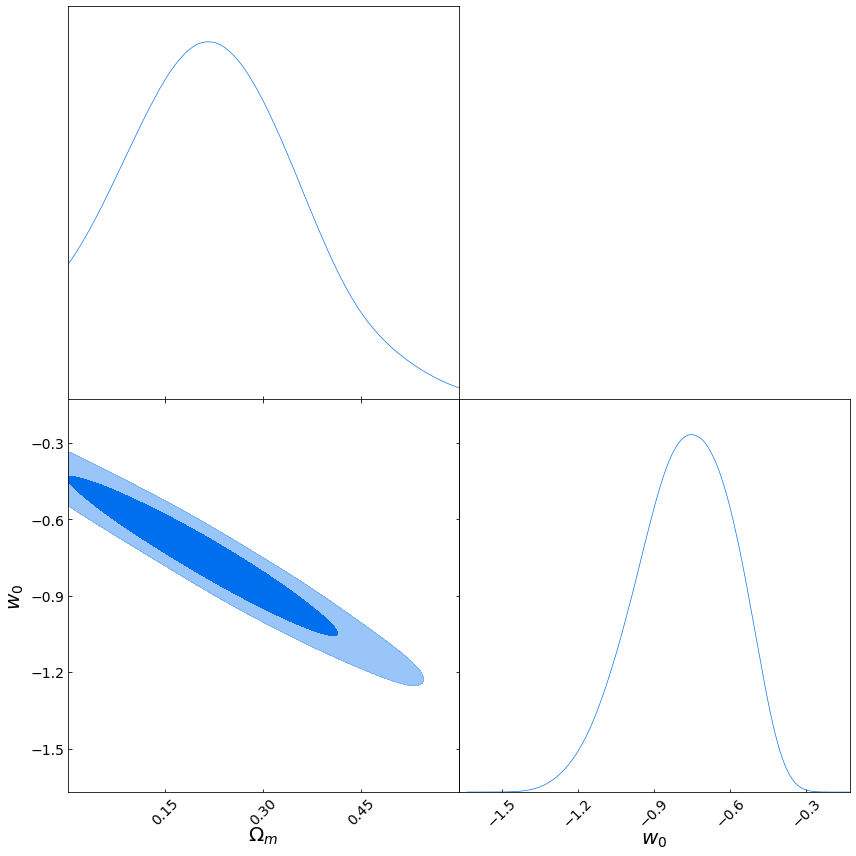

In [6]:
# Proposal for the Fisher pre-training stage
proposal = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Do the Fisher pre-training
mdn.fisher_pretraining(50000, proposal, epochs=100)

Running initial 200 sims...
Done.
Train on 180 samples, validate on 20 samples
Epoch 1/100
180/180 [==============================] - 0s 1ms/step - loss: 2.4601 - val_loss: 3.1943
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 2.1531 - val_loss: 2.3817
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 1.9241 - val_loss: 1.9738
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 1.7945 - val_loss: 1.8271
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 1.6912 - val_loss: 1.8416
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 1.6989 - val_loss: 1.7006
Epoch 7/100
180/180 [==============================] - 0s 1ms/step - loss: 1.6607 - val_loss: 1.5826
Epoch 8/100
180/180 [==============================] - 0s 1ms/step - loss: 1.6160 - val_loss: 1.6982
Epoch 9/100
180/180 [==============================] - 0s 1ms/step - loss: 1.5461 - val_loss: 1.5458
Epoch 10/100

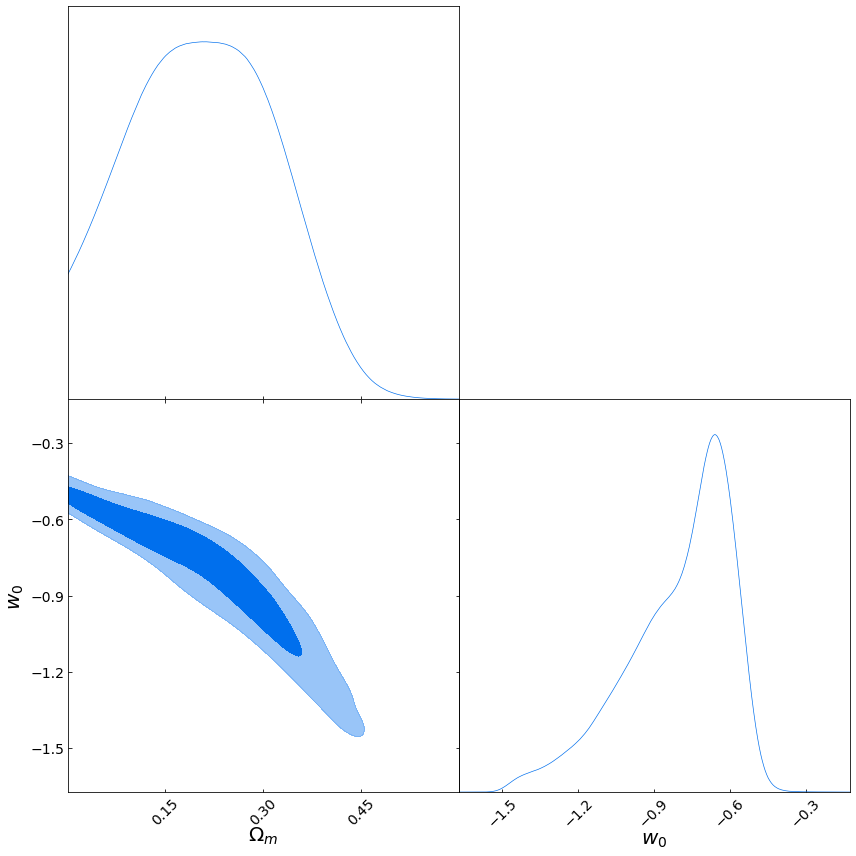

Population 1/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 360 samples, validate on 40 samples
Epoch 1/100
360/360 [==============================] - 0s 1ms/step - loss: 1.4071 - val_loss: 1.7740
Epoch 2/100
360/360 [==============================] - 0s 1ms/step - loss: 1.4101 - val_loss: 1.7057
Epoch 3/100
360/360 [==============================] - 0s 1ms/step - loss: 1.3657 - val_loss: 1.7170
Epoch 4/100
360/360 [==============================] - 1s 2ms/step - loss: 1.3681 - val_loss: 1.7267
Epoch 5/100
360/360 [==============================] - 1s 1ms/step - loss: 1.3600 - val_loss: 1.7265
Epoch 6/100
360/360 [==============================] - 1s 1ms/step - loss: 1.3506 - val_loss: 1.7276
Epoch 7/100
360/360 [==============================] - 1s 2ms/step - loss: 1.3378 - val_loss: 1.7128
Epoch 8/100
360/360 [==============================] - 1s 1ms/step - loss: 1.3327 - val_loss: 1.6570
Epoch 9/100
360/360 [==============================] - 1s 1ms/step - l

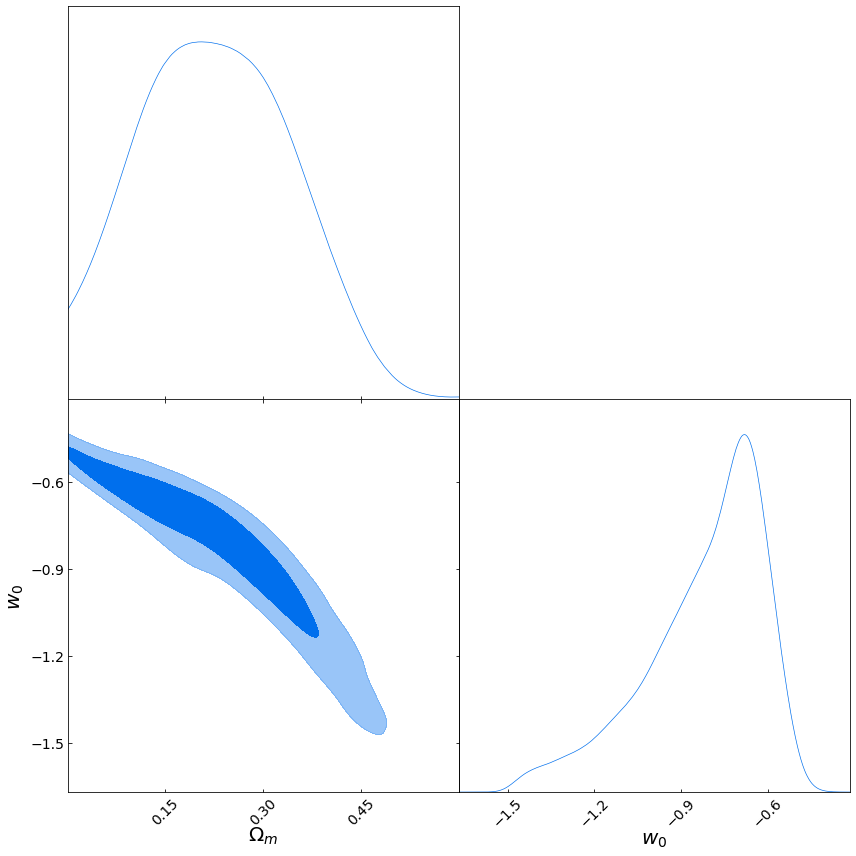

Population 2/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 540 samples, validate on 60 samples
Epoch 1/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3749 - val_loss: 1.2499
Epoch 2/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3876 - val_loss: 1.3296
Epoch 3/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3709 - val_loss: 1.2618
Epoch 4/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3654 - val_loss: 1.3427
Epoch 5/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3921 - val_loss: 1.2533
Epoch 6/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3754 - val_loss: 1.2657
Epoch 7/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3614 - val_loss: 1.2622
Epoch 8/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3599 - val_loss: 1.2766
Epoch 9/100
540/540 [==============================] - 1s 1ms/step - l

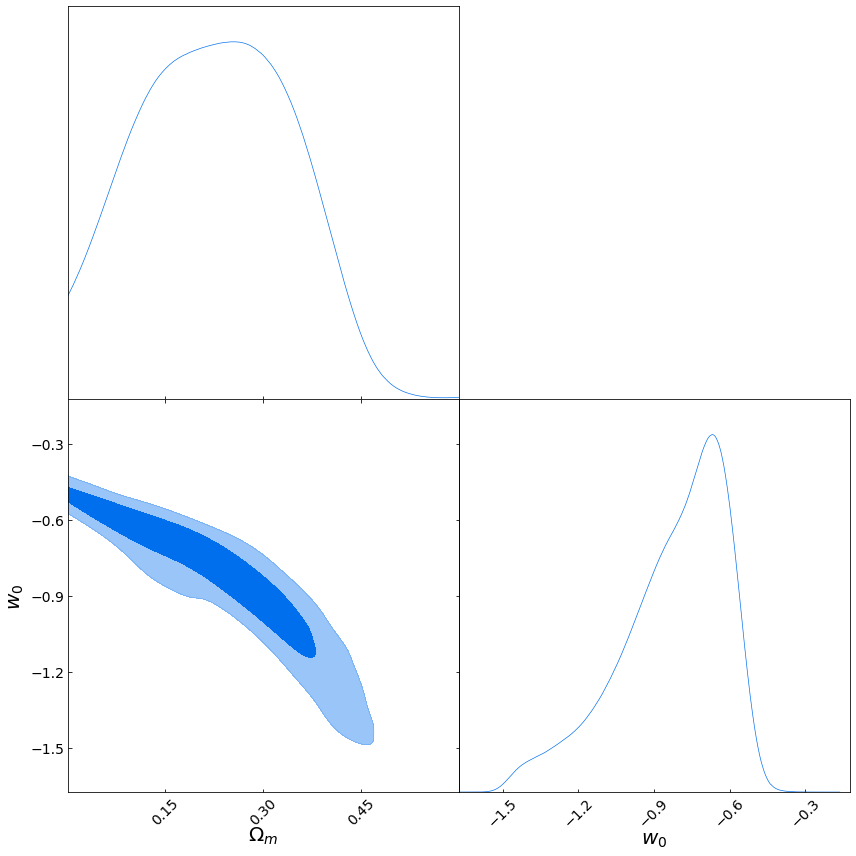

Population 3/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3623 - val_loss: 1.4837
Epoch 2/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3549 - val_loss: 1.4661
Epoch 3/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3579 - val_loss: 1.4667
Epoch 4/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3553 - val_loss: 1.4697
Epoch 5/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3529 - val_loss: 1.4798
Epoch 6/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3515 - val_loss: 1.4719
Epoch 7/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3547 - val_loss: 1.4988
Epoch 8/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3744 - val_loss: 1.4414
Epoch 9/100
720/720 [==============================] - 1s 1ms/step - l

720/720 [==============================] - 1s 1ms/step - loss: 1.3428 - val_loss: 1.4412
Epoch 81/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3440 - val_loss: 1.4521
Epoch 82/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3414 - val_loss: 1.4271
Epoch 83/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3454 - val_loss: 1.4272
Epoch 84/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3471 - val_loss: 1.4289
Epoch 85/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3481 - val_loss: 1.4721
Epoch 86/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3489 - val_loss: 1.4257
Epoch 87/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3566 - val_loss: 1.4886
Epoch 88/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3556 - val_loss: 1.4095
Sampling approximate posterior...
Done.


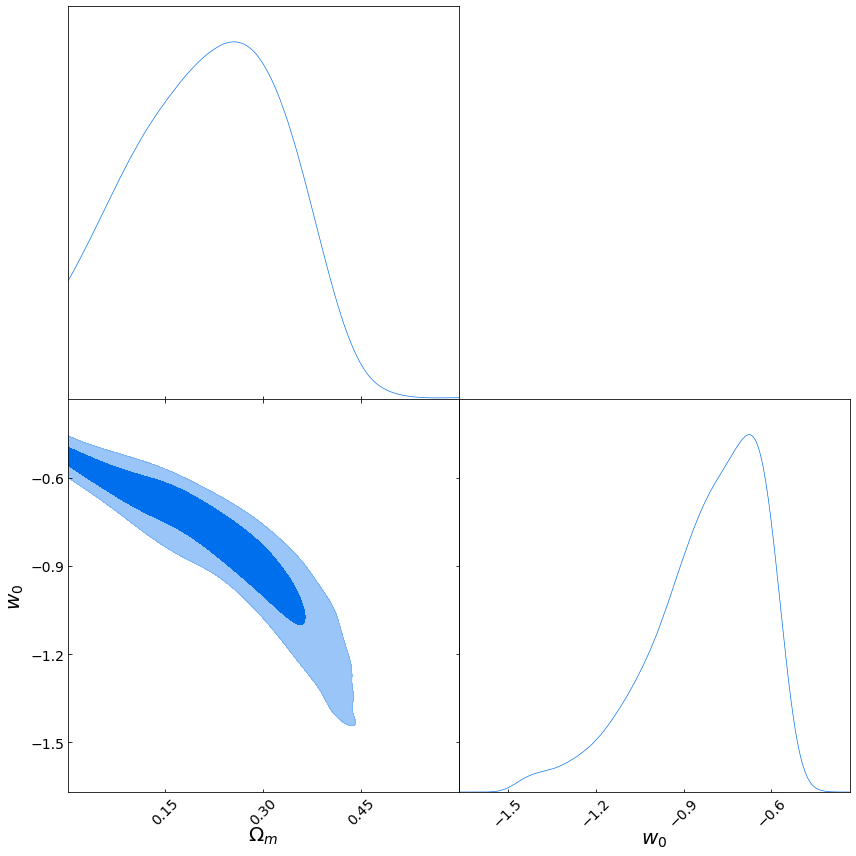

Population 4/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3364 - val_loss: 1.4351
Epoch 2/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3447 - val_loss: 1.4265
Epoch 3/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3446 - val_loss: 1.4213
Epoch 4/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3353 - val_loss: 1.4346
Epoch 5/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3415 - val_loss: 1.4306
Epoch 6/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3318 - val_loss: 1.4135
Epoch 7/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3306 - val_loss: 1.4289
Epoch 8/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3272 - val_loss: 1.4200
Epoch 9/100
900/900 [==============================] - 1s 1ms/step - 

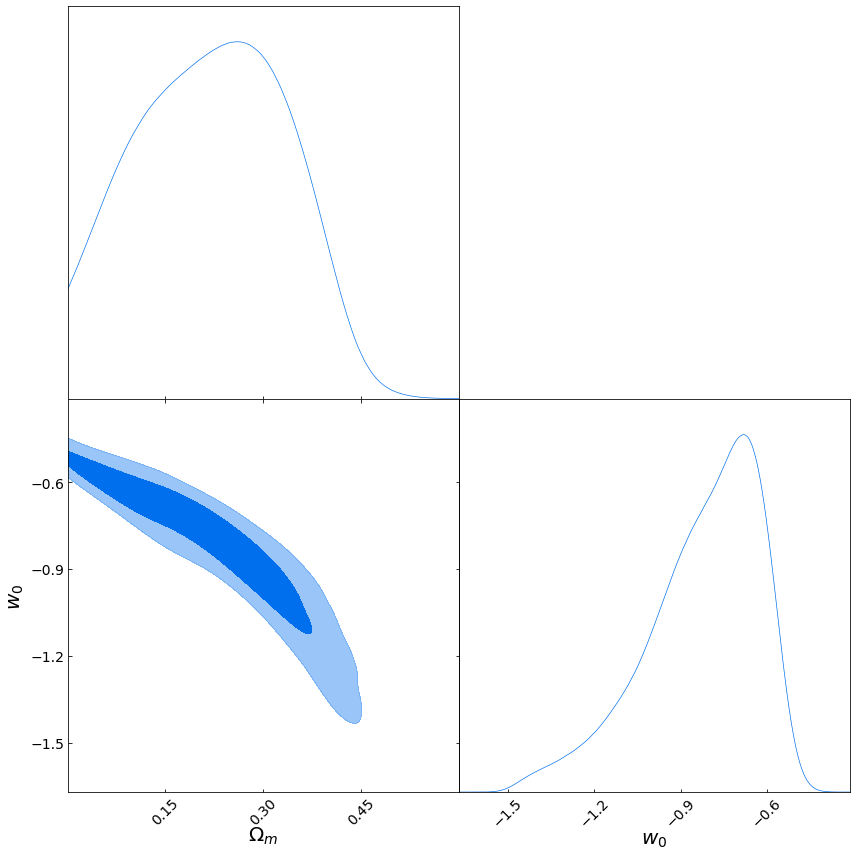

Population 5/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1080 samples, validate on 120 samples
Epoch 1/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3427 - val_loss: 1.4725
Epoch 2/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3468 - val_loss: 1.4565
Epoch 3/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3397 - val_loss: 1.4483
Epoch 4/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3348 - val_loss: 1.4498
Epoch 5/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3406 - val_loss: 1.4527
Epoch 6/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3387 - val_loss: 1.4519
Epoch 7/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3424 - val_loss: 1.4464
Epoch 8/100
1080/1080 [==============================] - 1s 1ms/step - loss: 1.3397 - val_loss: 1.4671
Epoch 9/100
1080/1080 [=============================

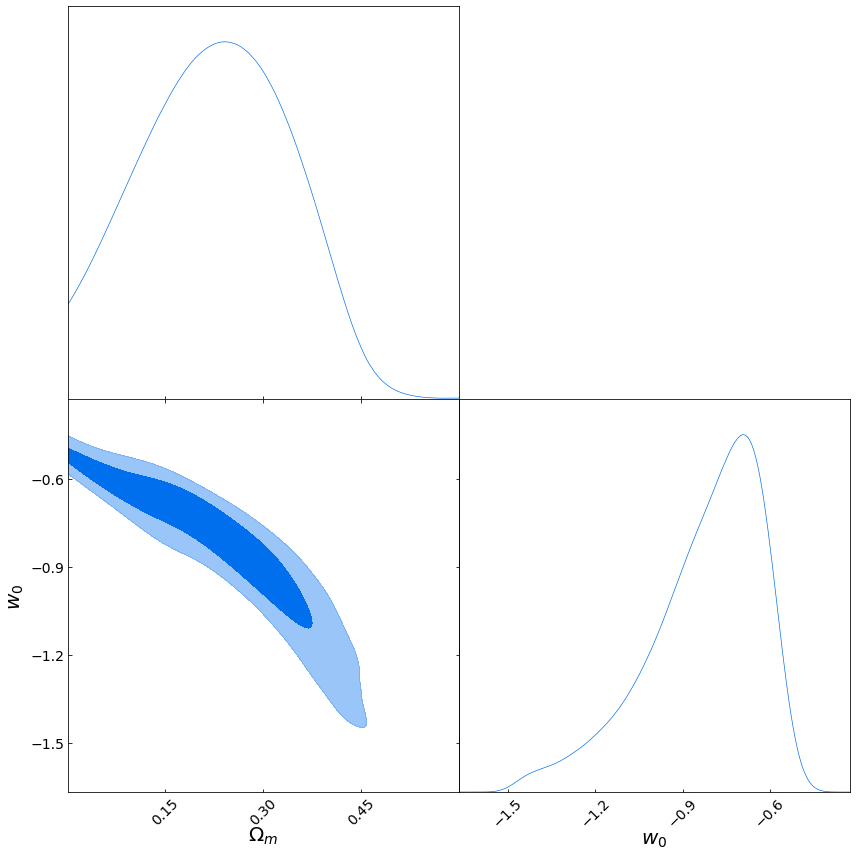

Population 6/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1260 samples, validate on 140 samples
Epoch 1/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3570 - val_loss: 1.4283
Epoch 2/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3620 - val_loss: 1.3982
Epoch 3/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3463 - val_loss: 1.4111
Epoch 4/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3509 - val_loss: 1.4001
Epoch 5/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3479 - val_loss: 1.3875
Epoch 6/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3484 - val_loss: 1.3929
Epoch 7/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3472 - val_loss: 1.3826
Epoch 8/100
1260/1260 [==============================] - 2s 1ms/step - loss: 1.3599 - val_loss: 1.3897
Epoch 9/100
1260/1260 [=============================

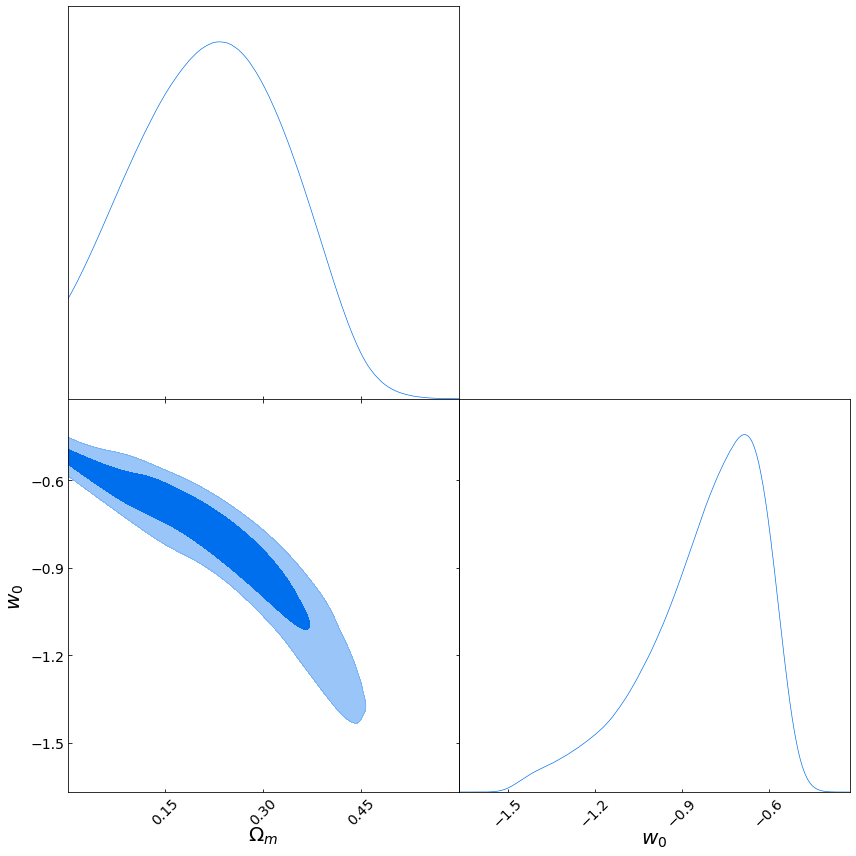

Population 7/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1440 samples, validate on 160 samples
Epoch 1/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3473 - val_loss: 1.3532
Epoch 2/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3485 - val_loss: 1.3829
Epoch 3/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3454 - val_loss: 1.3574
Epoch 4/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3494 - val_loss: 1.3960
Epoch 5/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3445 - val_loss: 1.3464
Epoch 6/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3564 - val_loss: 1.3770
Epoch 7/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3505 - val_loss: 1.3736
Epoch 8/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3462 - val_loss: 1.3482
Epoch 9/100
1440/1440 [=============================

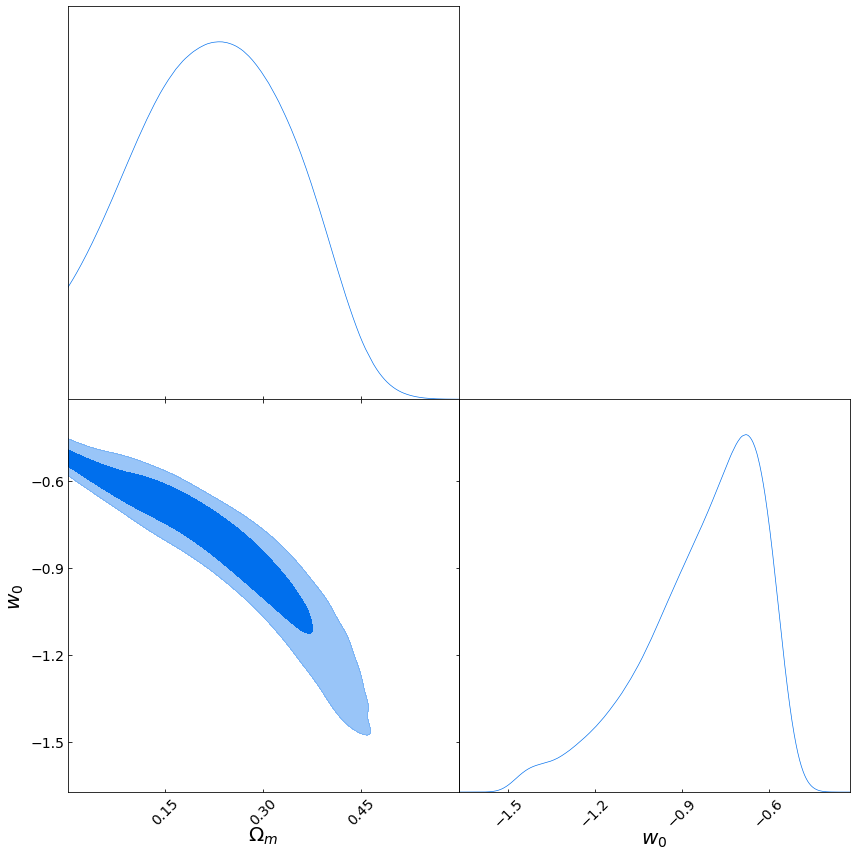

Population 8/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1620 samples, validate on 180 samples
Epoch 1/100
1620/1620 [==============================] - 2s 2ms/step - loss: 1.3439 - val_loss: 1.3450
Epoch 2/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3374 - val_loss: 1.3339
Epoch 3/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3365 - val_loss: 1.3393
Epoch 4/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3376 - val_loss: 1.3438
Epoch 5/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3375 - val_loss: 1.3314
Epoch 6/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3364 - val_loss: 1.3312
Epoch 7/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3379 - val_loss: 1.3360
Epoch 8/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3366 - val_loss: 1.3382
Epoch 9/100
1620/1620 [=============================

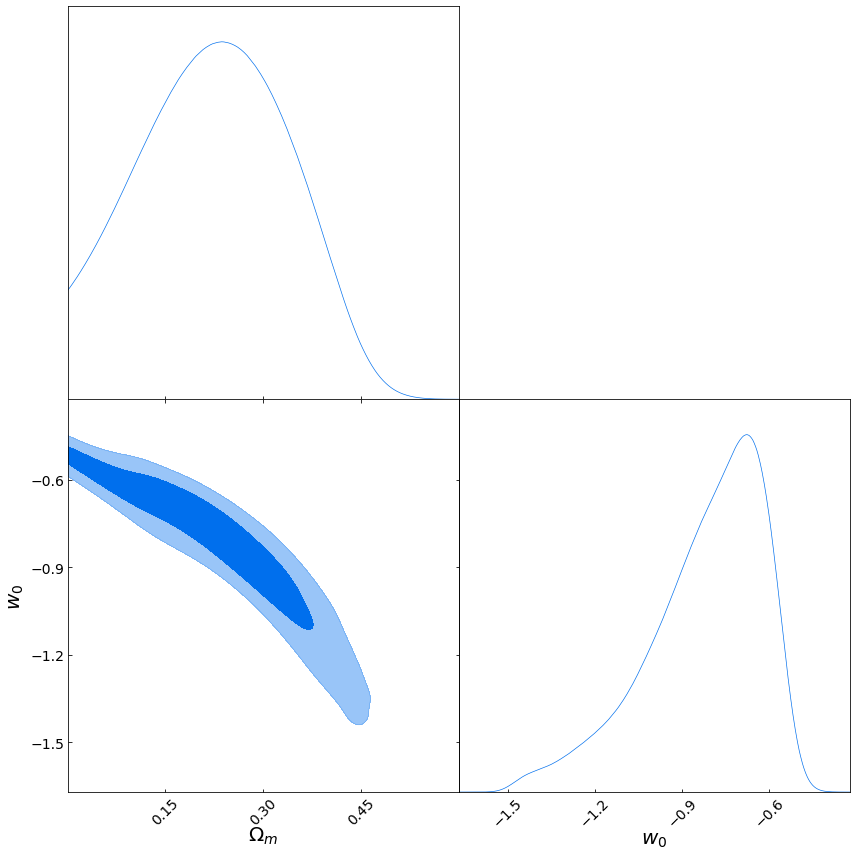

Population 9/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.3323 - val_loss: 1.4163
Epoch 2/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.3375 - val_loss: 1.4241
Epoch 3/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.3380 - val_loss: 1.4213
Epoch 4/100
1800/1800 [==============================] - 3s 1ms/step - loss: 1.3324 - val_loss: 1.4069
Epoch 5/100
1800/1800 [==============================] - 3s 1ms/step - loss: 1.3303 - val_loss: 1.4264
Epoch 6/100
1800/1800 [==============================] - 2s 1ms/step - loss: 1.3388 - val_loss: 1.4138
Epoch 7/100
1800/1800 [==============================] - 3s 1ms/step - loss: 1.3324 - val_loss: 1.4088
Epoch 8/100
1800/1800 [==============================] - 3s 1ms/step - loss: 1.3314 - val_loss: 1.3971
Epoch 9/100
1800/1800 [=============================

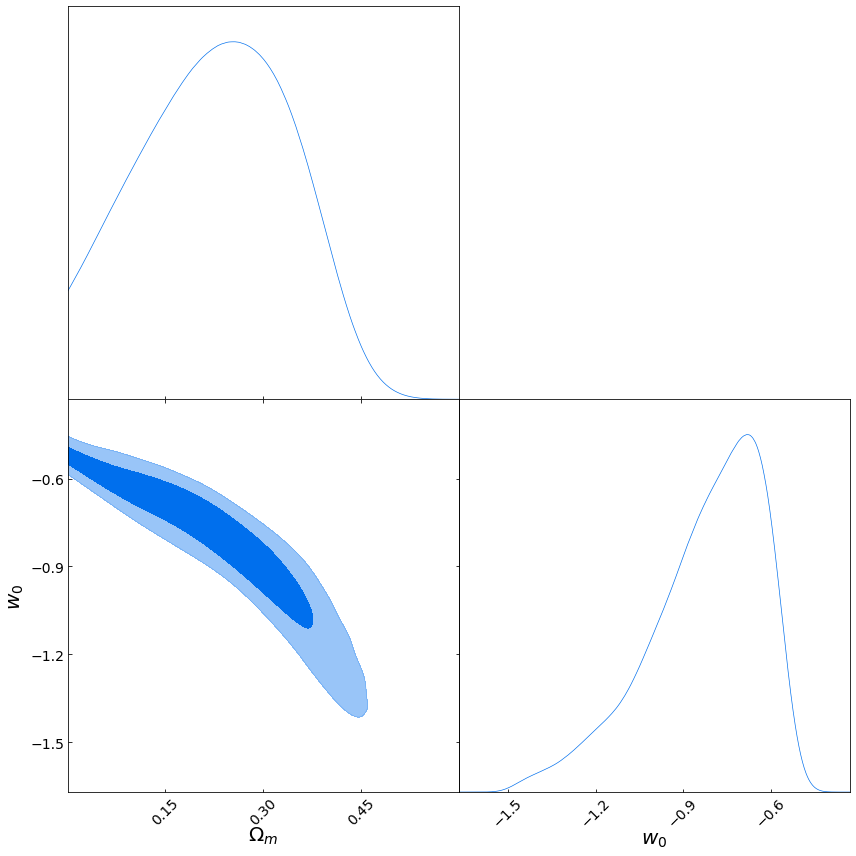

Population 10/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1980 samples, validate on 220 samples
Epoch 1/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3472 - val_loss: 1.2826
Epoch 2/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3438 - val_loss: 1.2953
Epoch 3/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3395 - val_loss: 1.2839
Epoch 4/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3448 - val_loss: 1.2879
Epoch 5/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3474 - val_loss: 1.2876
Epoch 6/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3439 - val_loss: 1.2983
Epoch 7/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3420 - val_loss: 1.2786
Epoch 8/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3452 - val_loss: 1.2858
Epoch 9/100
1980/1980 [============================

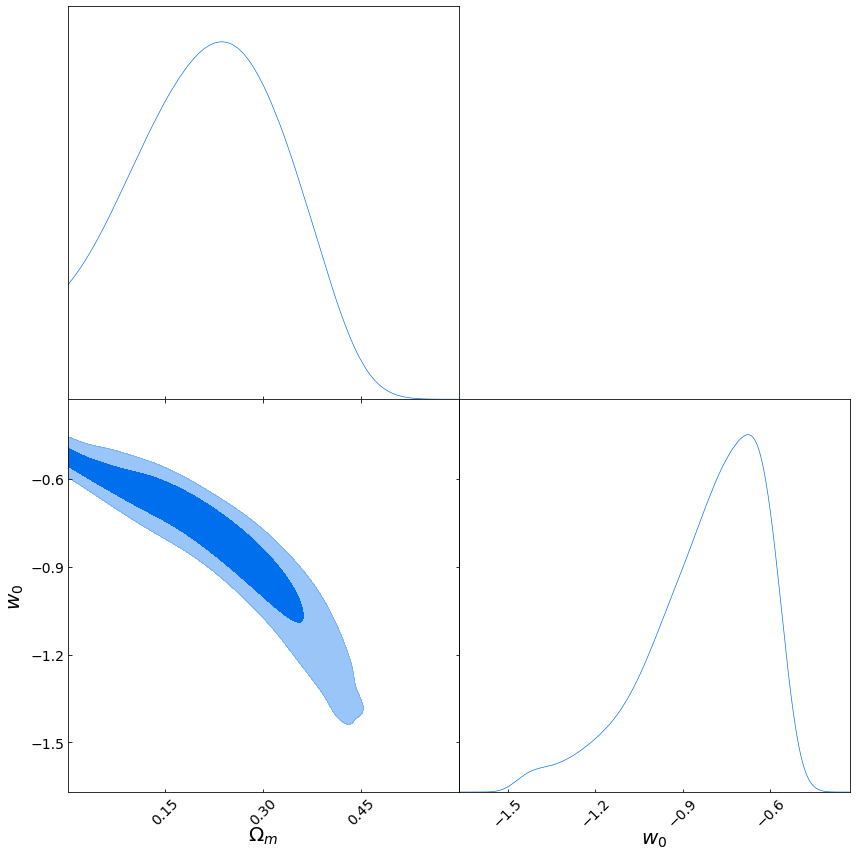

Population 11/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2160 samples, validate on 240 samples
Epoch 1/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3430 - val_loss: 1.4048
Epoch 2/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3298 - val_loss: 1.3923
Epoch 3/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3338 - val_loss: 1.4131
Epoch 4/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3383 - val_loss: 1.3879
Epoch 5/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3332 - val_loss: 1.3910
Epoch 6/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3345 - val_loss: 1.3989
Epoch 7/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3336 - val_loss: 1.3811
Epoch 8/100
2160/2160 [==============================] - 3s 1ms/step - loss: 1.3343 - val_loss: 1.3945
Epoch 9/100
2160/2160 [============================

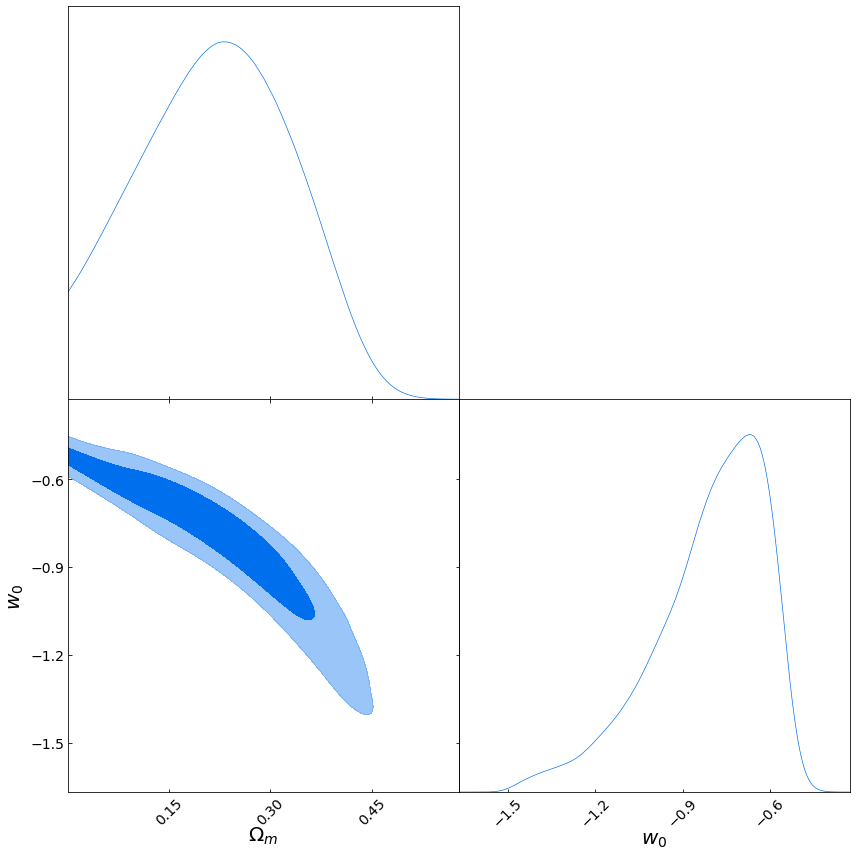

Population 12/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2340 samples, validate on 260 samples
Epoch 1/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3419 - val_loss: 1.2557
Epoch 2/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3398 - val_loss: 1.2636
Epoch 3/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3352 - val_loss: 1.2561
Epoch 4/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3353 - val_loss: 1.2542
Epoch 5/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3348 - val_loss: 1.2524
Epoch 6/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3351 - val_loss: 1.2517
Epoch 7/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3367 - val_loss: 1.2648
Epoch 8/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3407 - val_loss: 1.2522
Epoch 9/100
2340/2340 [============================

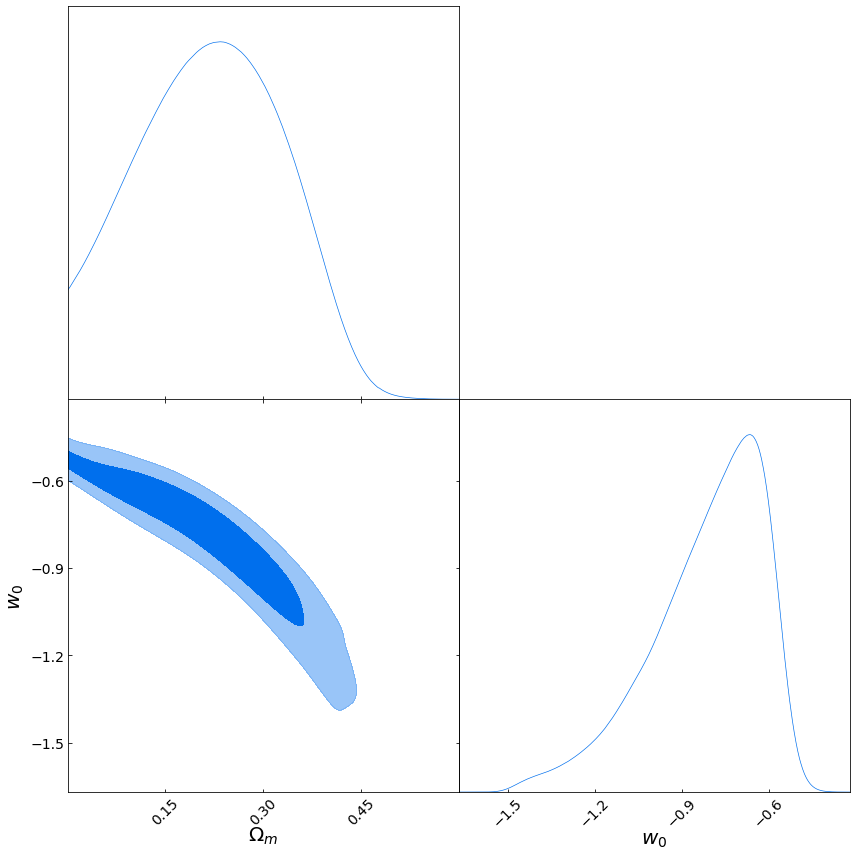

Population 13/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2520 samples, validate on 280 samples
Epoch 1/100
2520/2520 [==============================] - 4s 2ms/step - loss: 1.3417 - val_loss: 1.2368
Epoch 2/100
2520/2520 [==============================] - 8s 3ms/step - loss: 1.3343 - val_loss: 1.2333
Epoch 3/100
2520/2520 [==============================] - 7s 3ms/step - loss: 1.3350 - val_loss: 1.2266
Epoch 4/100
2520/2520 [==============================] - 5s 2ms/step - loss: 1.3354 - val_loss: 1.2309
Epoch 5/100
2520/2520 [==============================] - 4s 1ms/step - loss: 1.3338 - val_loss: 1.2357
Epoch 6/100
2520/2520 [==============================] - 5s 2ms/step - loss: 1.3340 - val_loss: 1.2346
Epoch 7/100
2520/2520 [==============================] - 4s 2ms/step - loss: 1.3326 - val_loss: 1.2253
Epoch 8/100
2520/2520 [==============================] - 4s 2ms/step - loss: 1.3323 - val_loss: 1.2252
Epoch 9/100
2520/2520 [============================

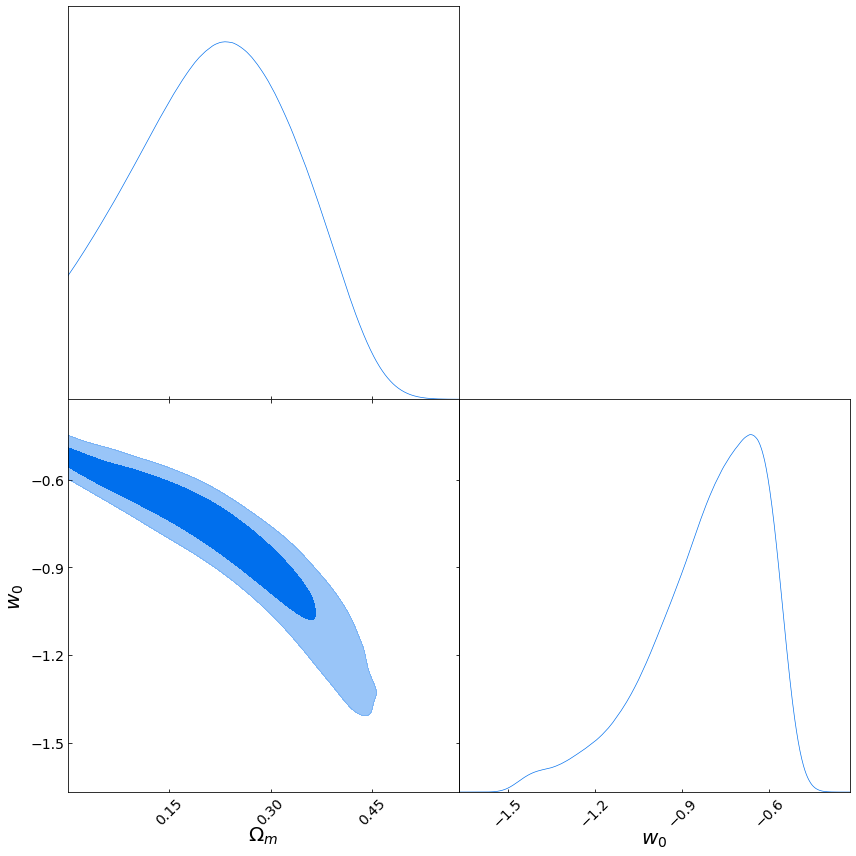

Population 14/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3217 - val_loss: 1.3307
Epoch 2/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3219 - val_loss: 1.3302
Epoch 3/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3242 - val_loss: 1.3299
Epoch 4/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3189 - val_loss: 1.3358
Epoch 5/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3201 - val_loss: 1.3394
Epoch 6/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3194 - val_loss: 1.3336
Epoch 7/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3194 - val_loss: 1.3323
Epoch 8/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3188 - val_loss: 1.3334
Epoch 9/100
2700/2700 [============================

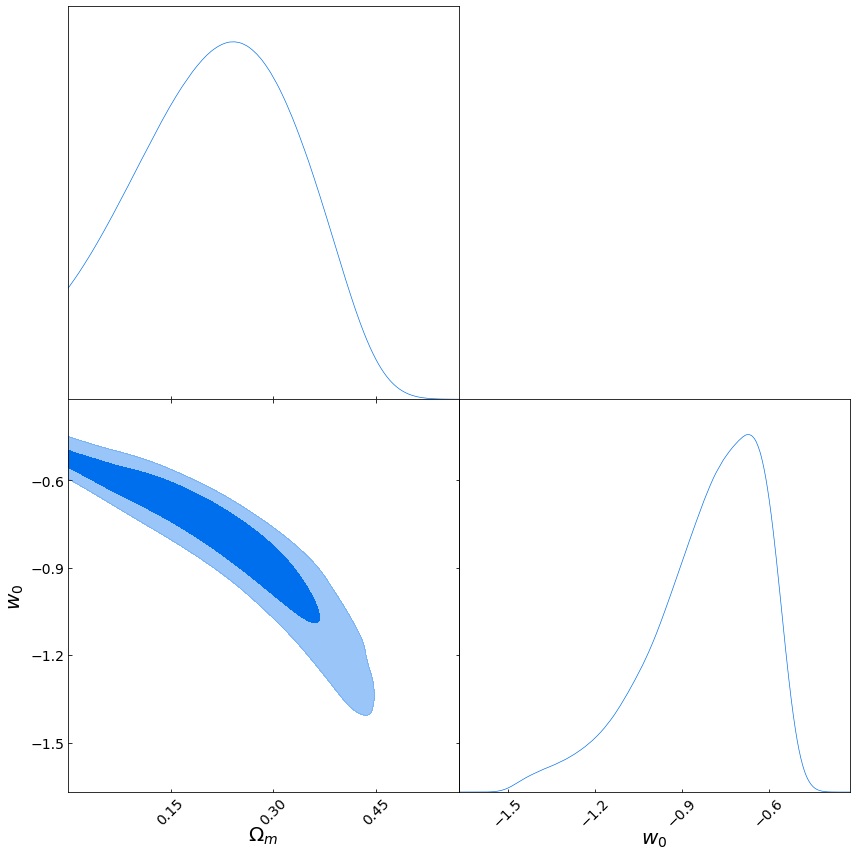

Population 15/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2880 samples, validate on 320 samples
Epoch 1/100
2880/2880 [==============================] - 8s 3ms/step - loss: 1.3182 - val_loss: 1.3947
Epoch 2/100
2880/2880 [==============================] - 12s 4ms/step - loss: 1.3191 - val_loss: 1.3888
Epoch 3/100
2880/2880 [==============================] - 6s 2ms/step - loss: 1.3218 - val_loss: 1.4119
Epoch 4/100
2880/2880 [==============================] - 5s 2ms/step - loss: 1.3266 - val_loss: 1.4137
Epoch 5/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3380 - val_loss: 1.3920
Epoch 6/100
2880/2880 [==============================] - 5s 2ms/step - loss: 1.3367 - val_loss: 1.4318
Epoch 7/100
2880/2880 [==============================] - 9s 3ms/step - loss: 1.3315 - val_loss: 1.4207
Epoch 8/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3341 - val_loss: 1.3884
Epoch 9/100
2880/2880 [===========================

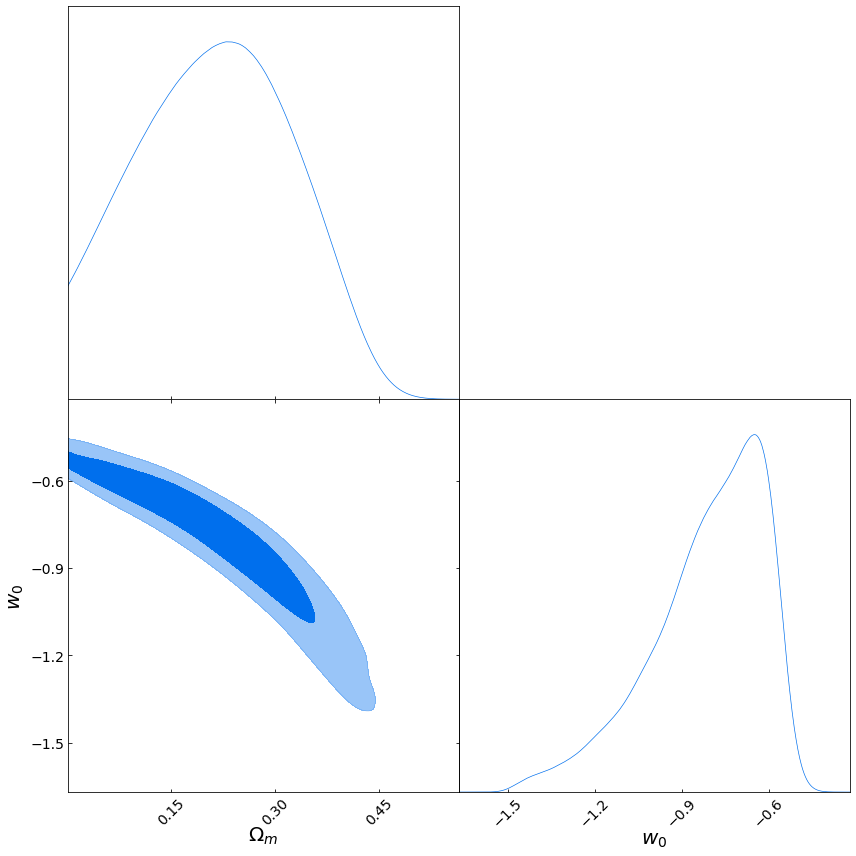

Population 16/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3060 samples, validate on 340 samples
Epoch 1/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3300 - val_loss: 1.3337
Epoch 2/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3255 - val_loss: 1.3375
Epoch 3/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3320 - val_loss: 1.3499
Epoch 4/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3235 - val_loss: 1.3311
Epoch 5/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3231 - val_loss: 1.3337
Epoch 6/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3264 - val_loss: 1.3540
Epoch 7/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3239 - val_loss: 1.3303
Epoch 8/100
3060/3060 [==============================] - 6s 2ms/step - loss: 1.3234 - val_loss: 1.3320
Epoch 9/100
3060/3060 [============================

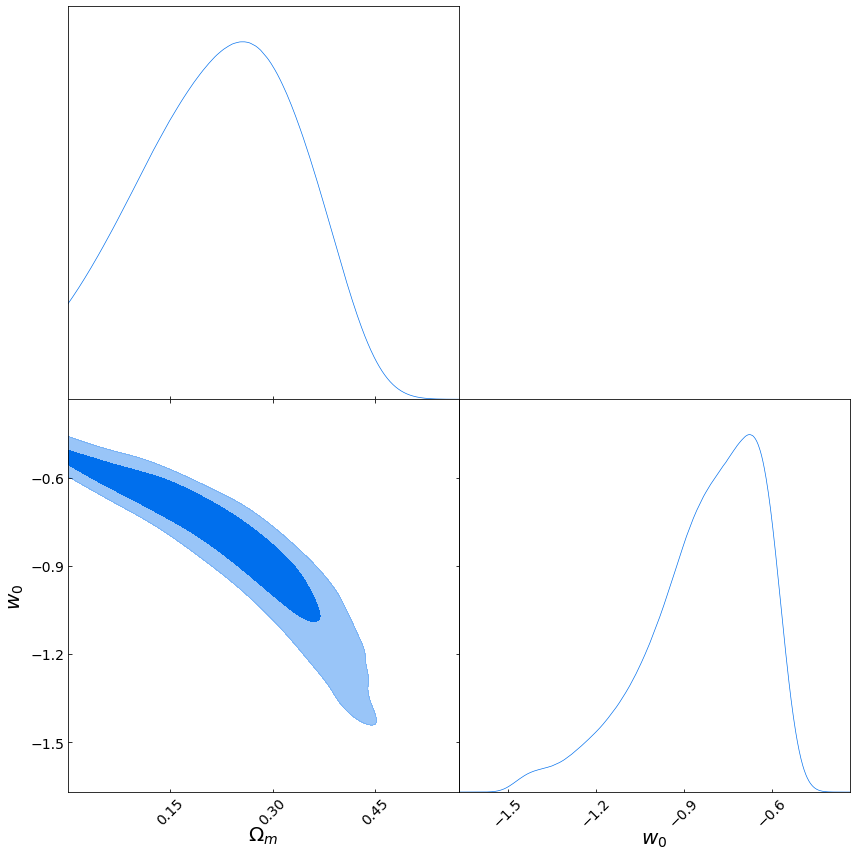

Population 17/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3240 samples, validate on 360 samples
Epoch 1/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3347 - val_loss: 1.2640
Epoch 2/100
3240/3240 [==============================] - 5s 2ms/step - loss: 1.3277 - val_loss: 1.2681
Epoch 3/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3259 - val_loss: 1.2623
Epoch 4/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3250 - val_loss: 1.2773
Epoch 5/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3308 - val_loss: 1.2605
Epoch 6/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3318 - val_loss: 1.2655
Epoch 7/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3276 - val_loss: 1.2750
Epoch 8/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3297 - val_loss: 1.2595
Epoch 9/100
3240/3240 [============================

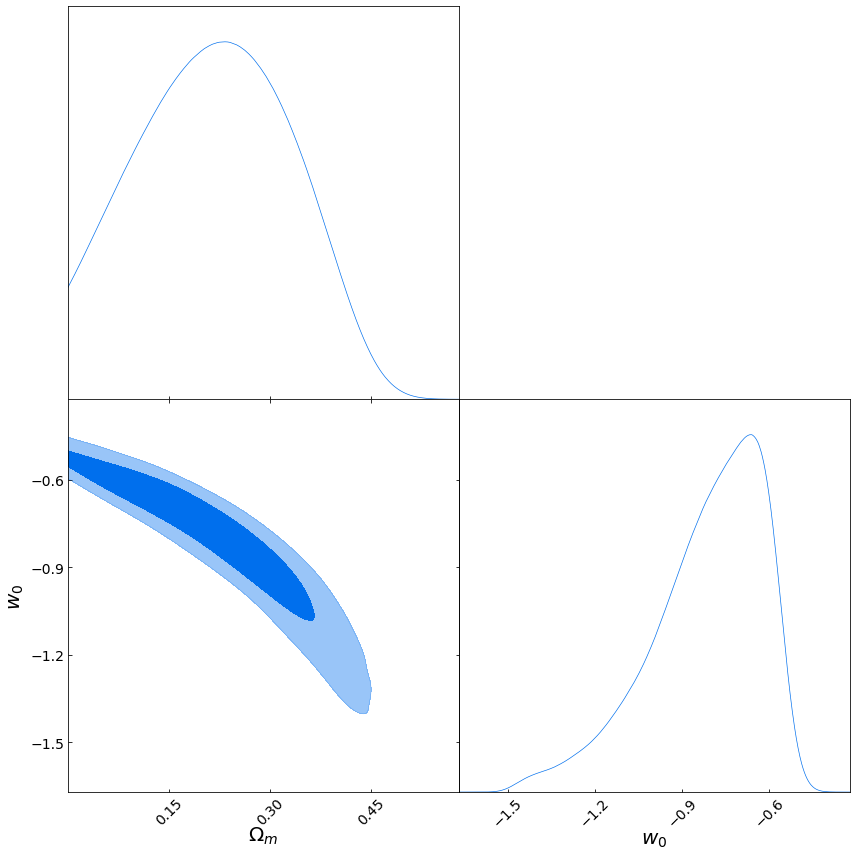

Population 18/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3420 samples, validate on 380 samples
Epoch 1/100
3420/3420 [==============================] - 5s 2ms/step - loss: 1.3276 - val_loss: 1.2897
Epoch 2/100
3420/3420 [==============================] - 5s 2ms/step - loss: 1.3230 - val_loss: 1.2917
Epoch 3/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3233 - val_loss: 1.2939
Epoch 4/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3232 - val_loss: 1.2859
Epoch 5/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3216 - val_loss: 1.2920
Epoch 6/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3228 - val_loss: 1.2963
Epoch 7/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3266 - val_loss: 1.2998
Epoch 8/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3234 - val_loss: 1.2862
Epoch 9/100
3420/3420 [============================

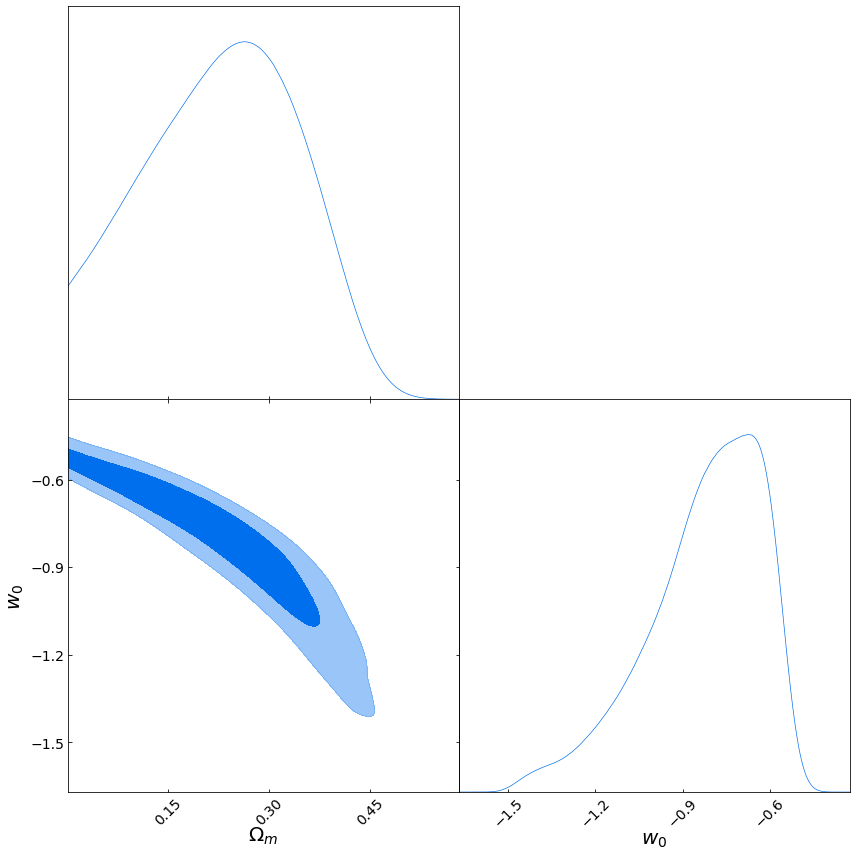

Population 19/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3162 - val_loss: 1.3052
Epoch 2/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3160 - val_loss: 1.3022
Epoch 3/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3162 - val_loss: 1.2998
Epoch 4/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3189 - val_loss: 1.3027
Epoch 5/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3180 - val_loss: 1.3104
Epoch 6/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3173 - val_loss: 1.3020
Epoch 7/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3163 - val_loss: 1.3120
Epoch 8/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3231 - val_loss: 1.3028
Epoch 9/100
3600/3600 [============================

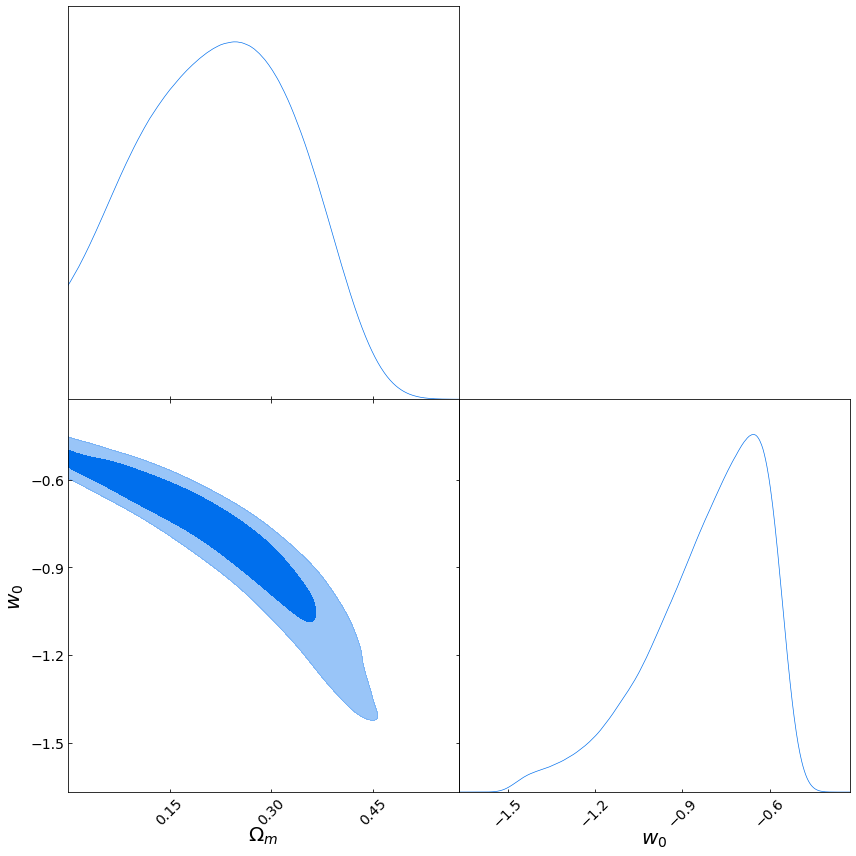

Population 20/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3780 samples, validate on 420 samples
Epoch 1/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3195 - val_loss: 1.3702
Epoch 2/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3159 - val_loss: 1.3657
Epoch 3/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3137 - val_loss: 1.3706
Epoch 4/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3145 - val_loss: 1.3712
Epoch 5/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3169 - val_loss: 1.3916
Epoch 6/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3218 - val_loss: 1.3744
Epoch 7/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3184 - val_loss: 1.3647
Epoch 8/100
3780/3780 [==============================] - 5s 1ms/step - loss: 1.3143 - val_loss: 1.3724
Epoch 9/100
3780/3780 [============================

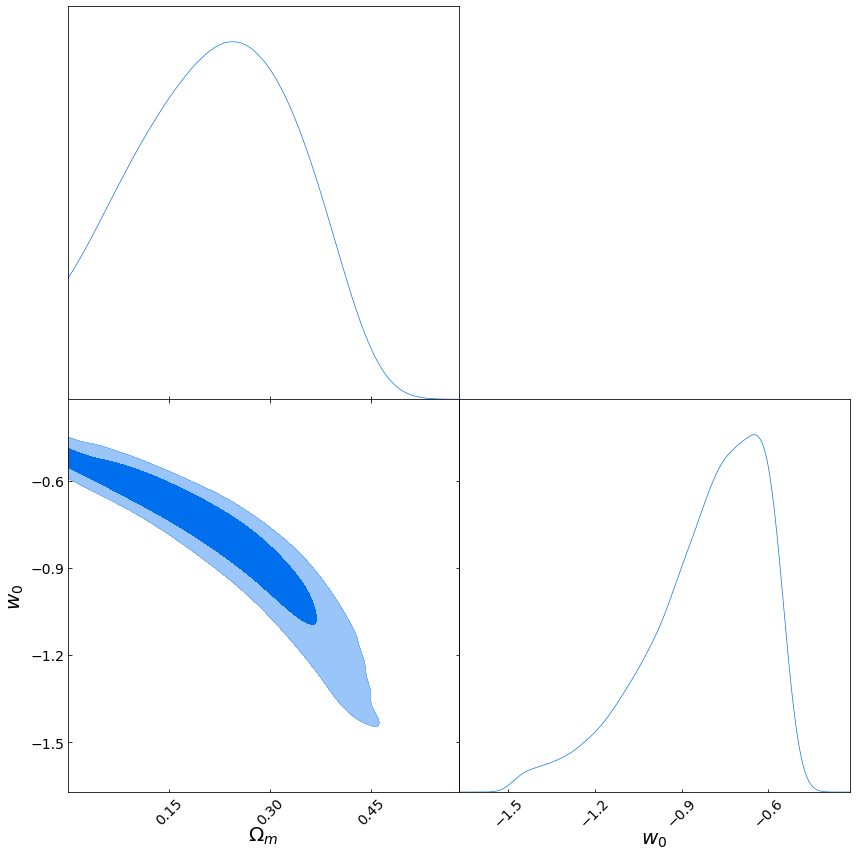

Population 21/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3960 samples, validate on 440 samples
Epoch 1/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3134 - val_loss: 1.4427
Epoch 2/100
3960/3960 [==============================] - 6s 1ms/step - loss: 1.3167 - val_loss: 1.4623
Epoch 3/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3176 - val_loss: 1.4507
Epoch 4/100
3960/3960 [==============================] - 7s 2ms/step - loss: 1.3151 - val_loss: 1.4398
Epoch 5/100
3960/3960 [==============================] - 6s 1ms/step - loss: 1.3142 - val_loss: 1.4457
Epoch 6/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3186 - val_loss: 1.4411
Epoch 7/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3166 - val_loss: 1.4418
Epoch 8/100
3960/3960 [==============================] - 6s 2ms/step - loss: 1.3115 - val_loss: 1.4458
Epoch 9/100
3960/3960 [============================

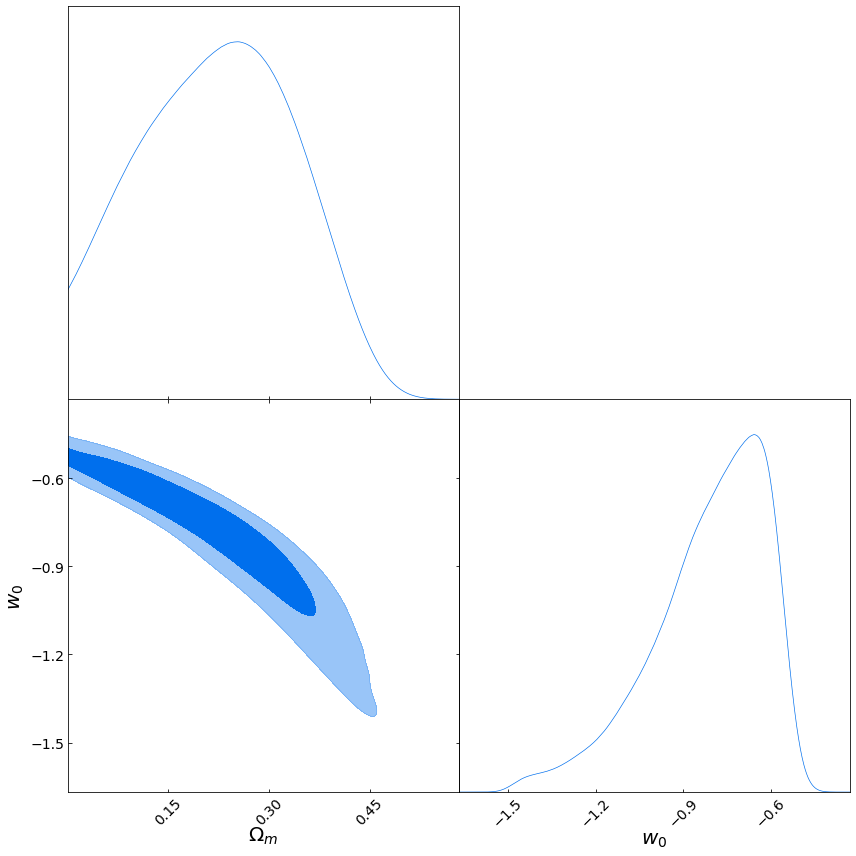

Population 22/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 4140 samples, validate on 460 samples
Epoch 1/100
4140/4140 [==============================] - 6s 1ms/step - loss: 1.3181 - val_loss: 1.4752
Epoch 2/100
4140/4140 [==============================] - 6s 1ms/step - loss: 1.3160 - val_loss: 1.4659
Epoch 3/100
4140/4140 [==============================] - 6s 2ms/step - loss: 1.3150 - val_loss: 1.4705
Epoch 4/100
4140/4140 [==============================] - 8s 2ms/step - loss: 1.3221 - val_loss: 1.4655
Epoch 5/100
4140/4140 [==============================] - 6s 1ms/step - loss: 1.3156 - val_loss: 1.4769
Epoch 6/100
4140/4140 [==============================] - 6s 2ms/step - loss: 1.3160 - val_loss: 1.4627
Epoch 7/100
4140/4140 [==============================] - 6s 2ms/step - loss: 1.3165 - val_loss: 1.4694
Epoch 8/100
4140/4140 [==============================] - 6s 2ms/step - loss: 1.3153 - val_loss: 1.4672
Epoch 9/100
4140/4140 [============================

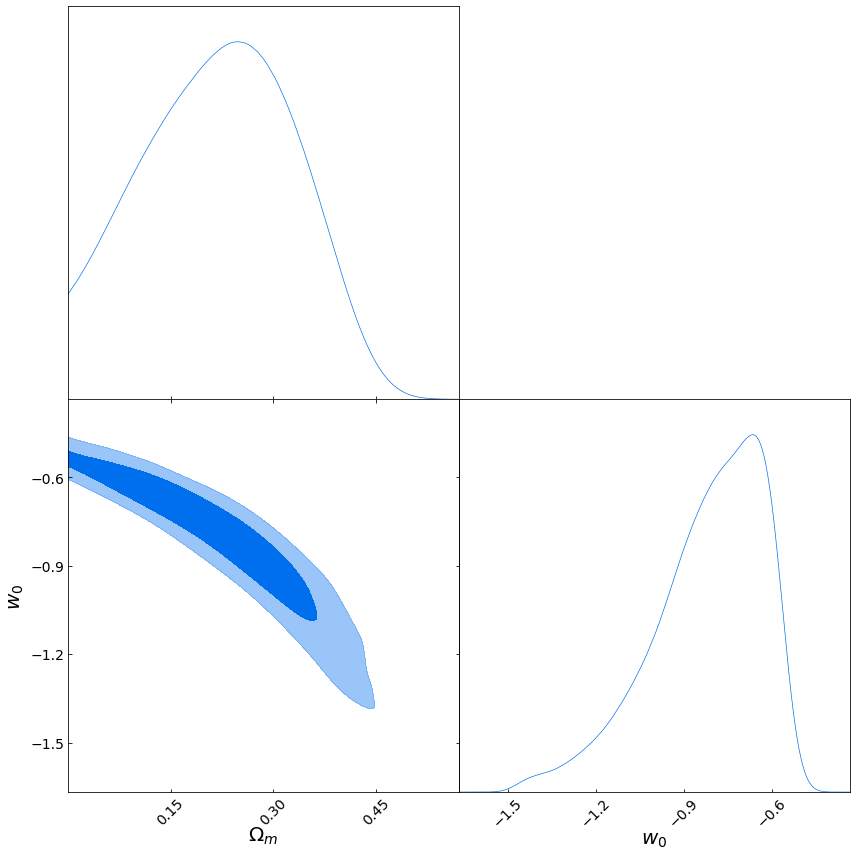

Population 23/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 4320 samples, validate on 480 samples
Epoch 1/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3208 - val_loss: 1.4223
Epoch 2/100
4320/4320 [==============================] - 7s 2ms/step - loss: 1.3224 - val_loss: 1.4250
Epoch 3/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3274 - val_loss: 1.4252
Epoch 4/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3241 - val_loss: 1.4221
Epoch 5/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3222 - val_loss: 1.4483
Epoch 6/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3235 - val_loss: 1.4191
Epoch 7/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3190 - val_loss: 1.4338
Epoch 8/100
4320/4320 [==============================] - 6s 1ms/step - loss: 1.3201 - val_loss: 1.4180
Epoch 9/100
4320/4320 [============================

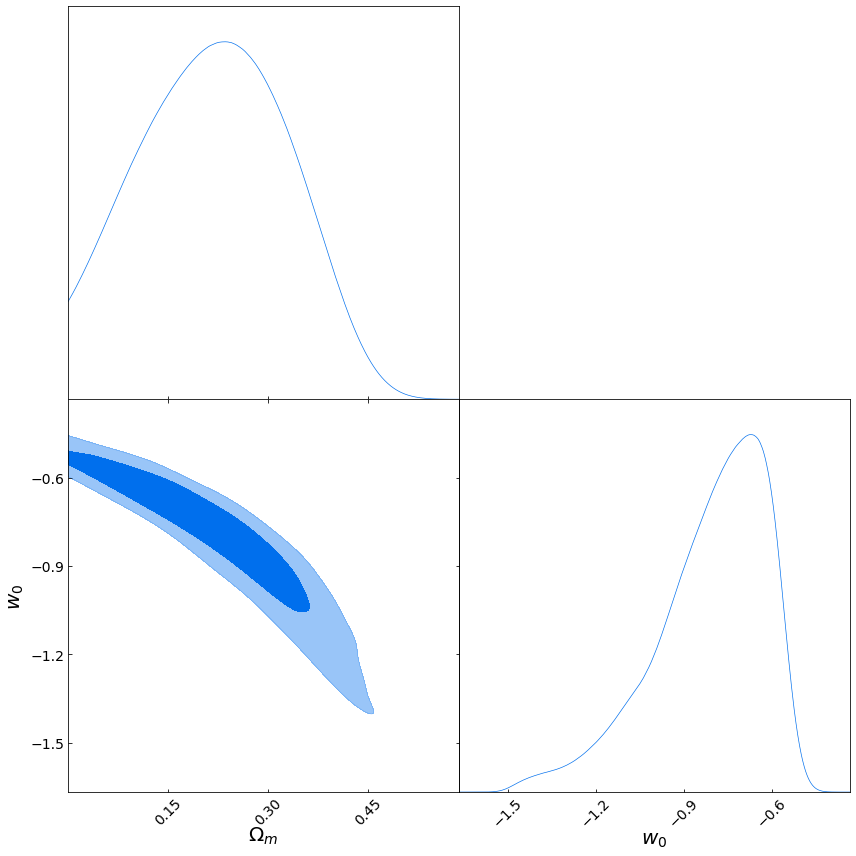

Population 24/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 7s 1ms/step - loss: 1.3267 - val_loss: 1.4150
Epoch 2/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3260 - val_loss: 1.4134
Epoch 3/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3248 - val_loss: 1.4247
Epoch 4/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3344 - val_loss: 1.4173
Epoch 5/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3309 - val_loss: 1.4322
Epoch 6/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3292 - val_loss: 1.4118
Epoch 7/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3291 - val_loss: 1.4268
Epoch 8/100
4500/4500 [==============================] - 6s 1ms/step - loss: 1.3280 - val_loss: 1.4151
Epoch 9/100
4500/4500 [============================

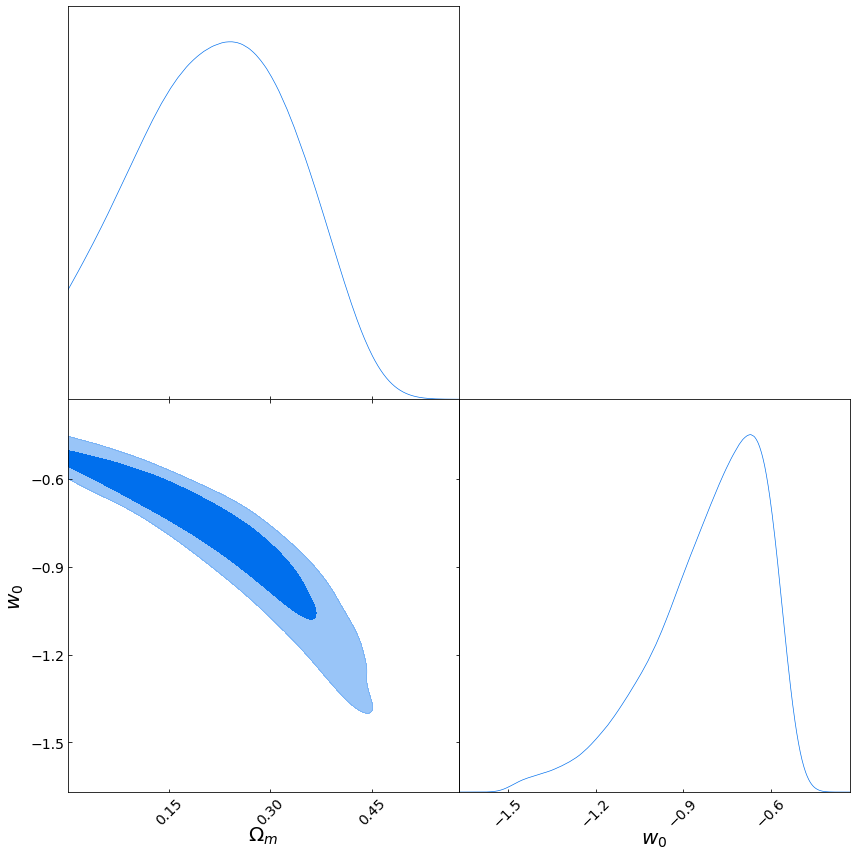

Population 25/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 4680 samples, validate on 520 samples
Epoch 1/100
4680/4680 [==============================] - 6s 1ms/step - loss: 1.3286 - val_loss: 1.3565
Epoch 2/100
4680/4680 [==============================] - 6s 1ms/step - loss: 1.3302 - val_loss: 1.3617
Epoch 3/100
4680/4680 [==============================] - 6s 1ms/step - loss: 1.3312 - val_loss: 1.3588
Epoch 4/100
4680/4680 [==============================] - 6s 1ms/step - loss: 1.3310 - val_loss: 1.3811
Epoch 5/100
4680/4680 [==============================] - 6s 1ms/step - loss: 1.3361 - val_loss: 1.3512
Epoch 6/100
4680/4680 [==============================] - 7s 1ms/step - loss: 1.3292 - val_loss: 1.3634
Epoch 7/100
4680/4680 [==============================] - 6s 1ms/step - loss: 1.3319 - val_loss: 1.3630
Epoch 8/100
4680/4680 [==============================] - 6s 1ms/step - loss: 1.3289 - val_loss: 1.3653
Epoch 9/100
4680/4680 [============================

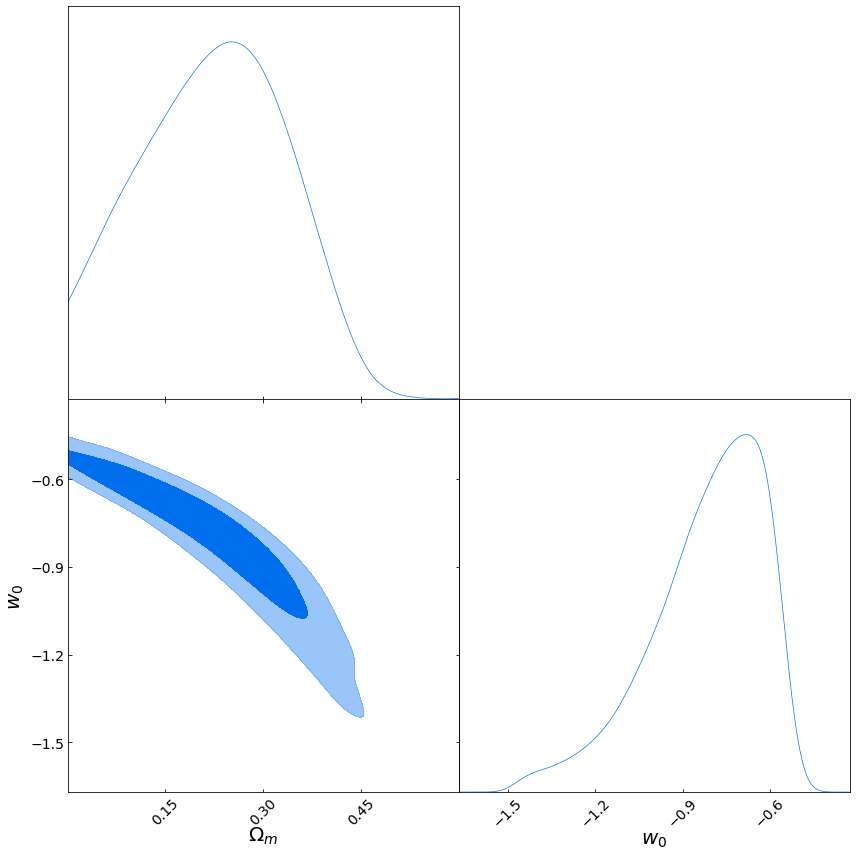

Population 26/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 4860 samples, validate on 540 samples
Epoch 1/100
4860/4860 [==============================] - 7s 1ms/step - loss: 1.3300 - val_loss: 1.3646
Epoch 2/100
4860/4860 [==============================] - 7s 2ms/step - loss: 1.3325 - val_loss: 1.3596
Epoch 3/100
4860/4860 [==============================] - 7s 1ms/step - loss: 1.3294 - val_loss: 1.3668
Epoch 4/100
4860/4860 [==============================] - 7s 1ms/step - loss: 1.3292 - val_loss: 1.3611
Epoch 5/100
4860/4860 [==============================] - 7s 1ms/step - loss: 1.3315 - val_loss: 1.3672
Epoch 6/100
4860/4860 [==============================] - 7s 1ms/step - loss: 1.3317 - val_loss: 1.3648
Epoch 7/100
4860/4860 [==============================] - 7s 2ms/step - loss: 1.3303 - val_loss: 1.3646
Epoch 8/100
4860/4860 [==============================] - 7s 1ms/step - loss: 1.3328 - val_loss: 1.3708
Epoch 9/100
4860/4860 [============================

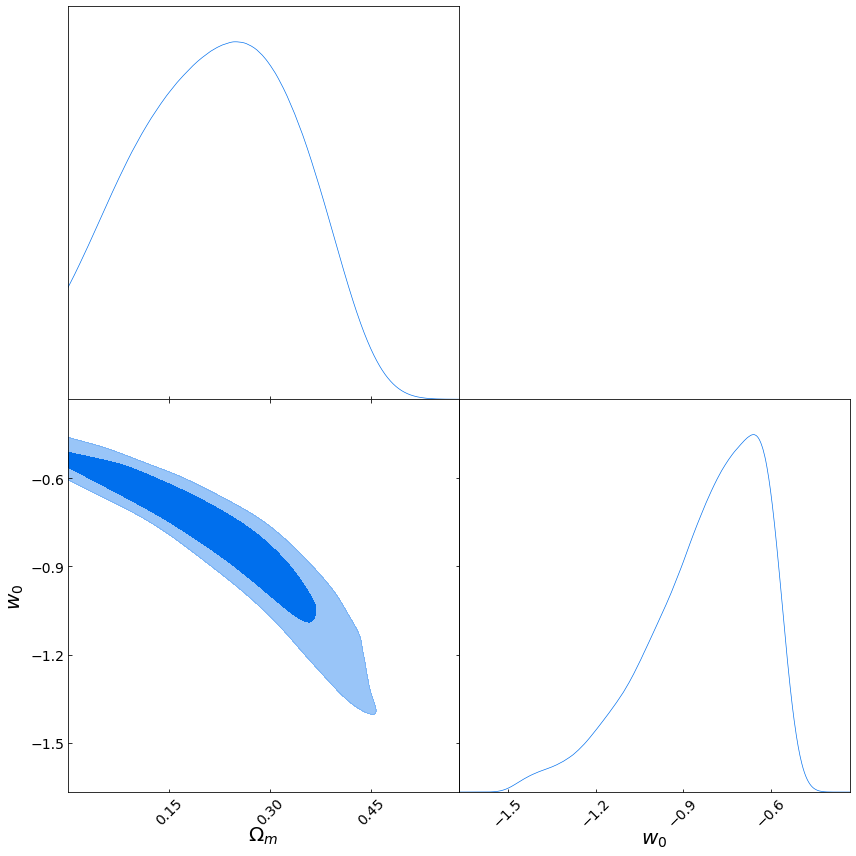

Population 27/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 5040 samples, validate on 560 samples
Epoch 1/100
5040/5040 [==============================] - 7s 1ms/step - loss: 1.3339 - val_loss: 1.3378
Epoch 2/100
5040/5040 [==============================] - 7s 1ms/step - loss: 1.3327 - val_loss: 1.3384
Epoch 3/100
5040/5040 [==============================] - 7s 1ms/step - loss: 1.3320 - val_loss: 1.3375
Epoch 4/100
5040/5040 [==============================] - 7s 1ms/step - loss: 1.3318 - val_loss: 1.3499
Epoch 5/100
5040/5040 [==============================] - 7s 1ms/step - loss: 1.3350 - val_loss: 1.3273
Epoch 6/100
5040/5040 [==============================] - 7s 1ms/step - loss: 1.3321 - val_loss: 1.3455
Epoch 7/100
5040/5040 [==============================] - 7s 1ms/step - loss: 1.3323 - val_loss: 1.3313
Epoch 8/100
5040/5040 [==============================] - 7s 1ms/step - loss: 1.3320 - val_loss: 1.3378
Epoch 9/100
5040/5040 [============================

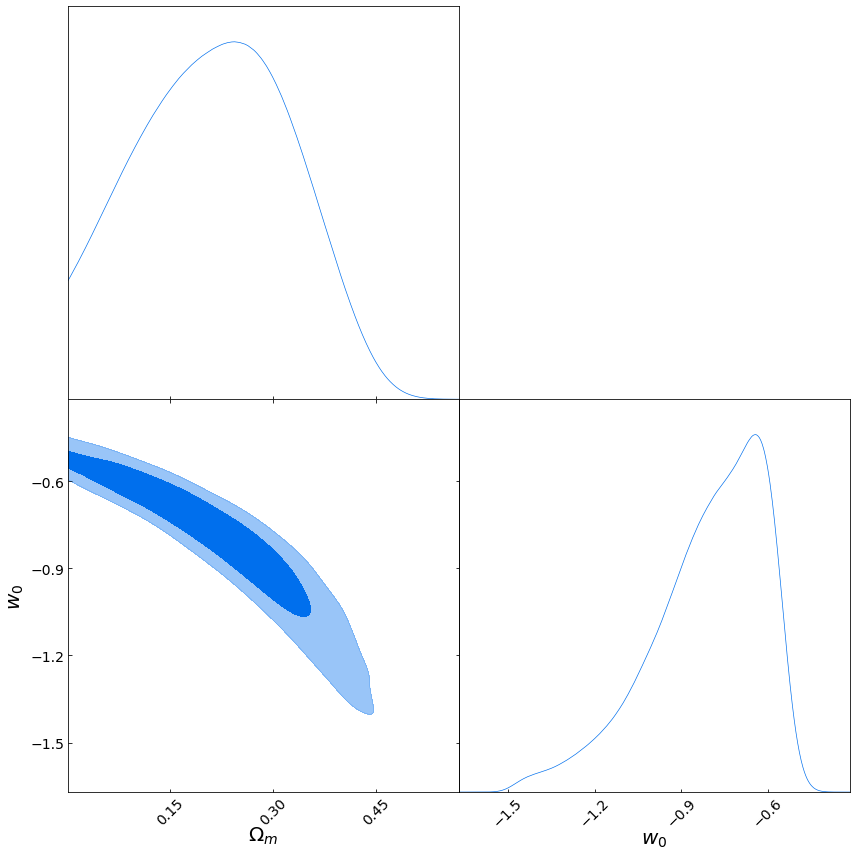

Population 28/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 5220 samples, validate on 580 samples
Epoch 1/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3327 - val_loss: 1.3579
Epoch 2/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3321 - val_loss: 1.3563
Epoch 3/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3302 - val_loss: 1.3644
Epoch 4/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3332 - val_loss: 1.3632
Epoch 5/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3348 - val_loss: 1.3642
Epoch 6/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3378 - val_loss: 1.3564
Epoch 7/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3347 - val_loss: 1.3700
Epoch 8/100
5220/5220 [==============================] - 7s 1ms/step - loss: 1.3355 - val_loss: 1.3567
Epoch 9/100
5220/5220 [============================

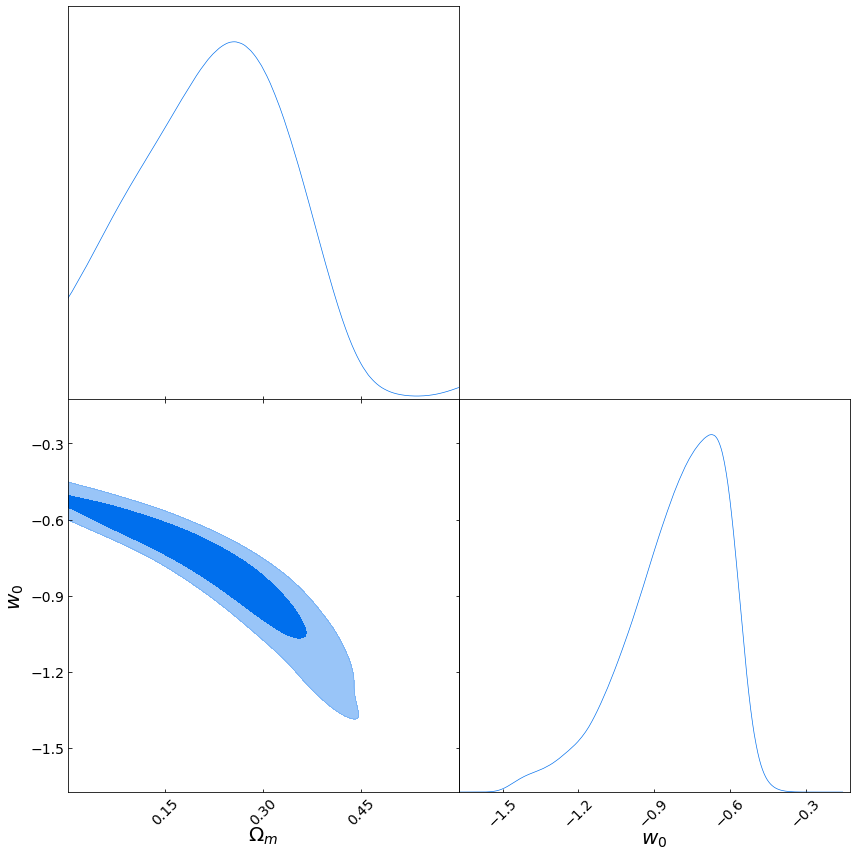

Population 29/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 5400 samples, validate on 600 samples
Epoch 1/100
5400/5400 [==============================] - 10s 2ms/step - loss: 1.3323 - val_loss: 1.3530
Epoch 2/100
5400/5400 [==============================] - 10s 2ms/step - loss: 1.3316 - val_loss: 1.3544
Epoch 3/100
5400/5400 [==============================] - 16s 3ms/step - loss: 1.3329 - val_loss: 1.3501
Epoch 4/100
5400/5400 [==============================] - 9s 2ms/step - loss: 1.3318 - val_loss: 1.3485
Epoch 5/100
5400/5400 [==============================] - 9s 2ms/step - loss: 1.3309 - val_loss: 1.3653
Epoch 6/100
5400/5400 [==============================] - 10s 2ms/step - loss: 1.3312 - val_loss: 1.3502
Epoch 7/100
5400/5400 [==============================] - 9s 2ms/step - loss: 1.3342 - val_loss: 1.3546
Epoch 8/100
5400/5400 [==============================] - 8s 1ms/step - loss: 1.3318 - val_loss: 1.3604
Epoch 9/100
5400/5400 [========================

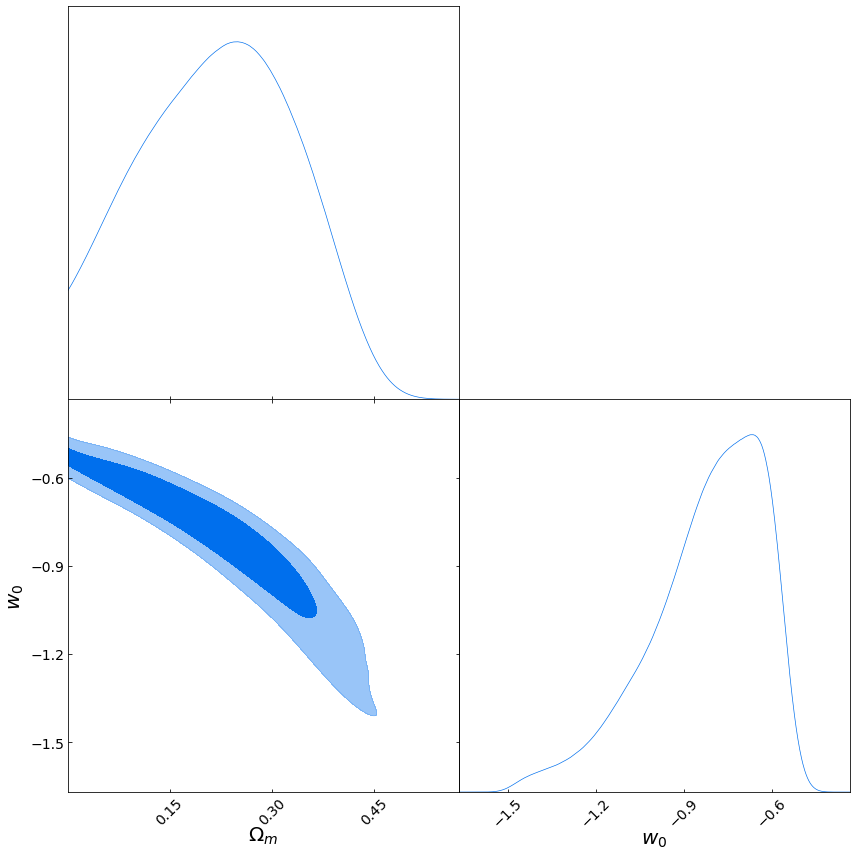

Population 30/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 5580 samples, validate on 620 samples
Epoch 1/100
5580/5580 [==============================] - 8s 1ms/step - loss: 1.3288 - val_loss: 1.3541
Epoch 2/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3318 - val_loss: 1.3490
Epoch 3/100
5580/5580 [==============================] - 8s 1ms/step - loss: 1.3279 - val_loss: 1.3518
Epoch 4/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3287 - val_loss: 1.3515
Epoch 5/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3278 - val_loss: 1.3532
Epoch 6/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3292 - val_loss: 1.3679
Epoch 7/100
5580/5580 [==============================] - 9s 2ms/step - loss: 1.3303 - val_loss: 1.3489
Epoch 8/100
5580/5580 [==============================] - 7s 1ms/step - loss: 1.3282 - val_loss: 1.3542
Epoch 9/100
5580/5580 [============================

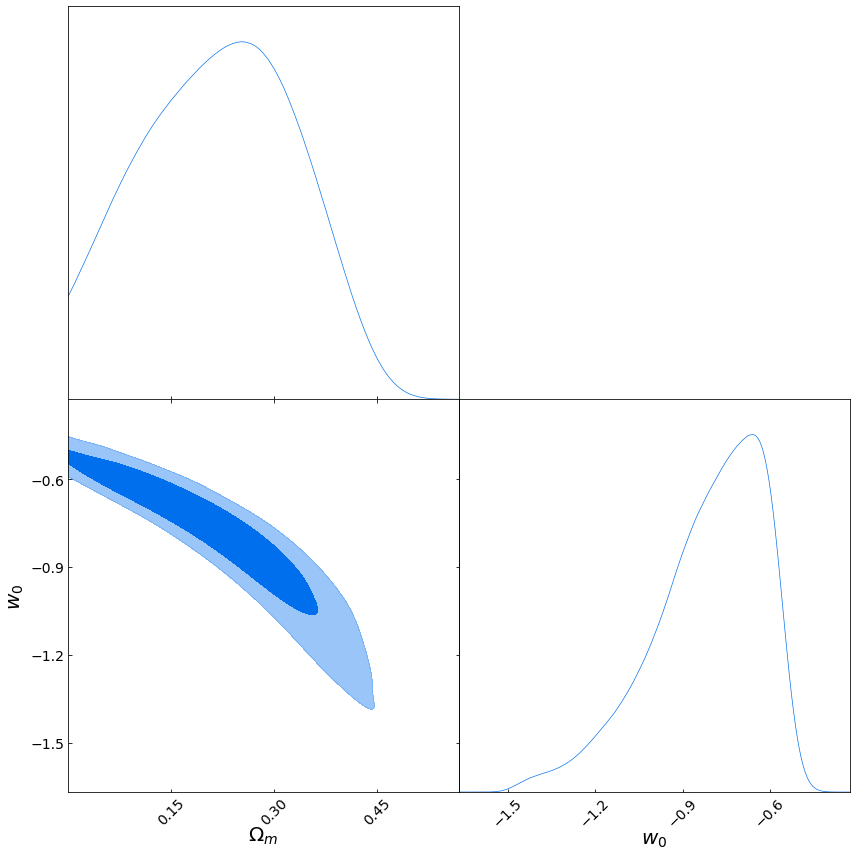

Population 31/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 5760 samples, validate on 640 samples
Epoch 1/100
5760/5760 [==============================] - 7s 1ms/step - loss: 1.3293 - val_loss: 1.3386
Epoch 2/100
5760/5760 [==============================] - 8s 1ms/step - loss: 1.3319 - val_loss: 1.3409
Epoch 3/100
5760/5760 [==============================] - 7s 1ms/step - loss: 1.3322 - val_loss: 1.3353
Epoch 4/100
5760/5760 [==============================] - 7s 1ms/step - loss: 1.3289 - val_loss: 1.3344
Epoch 5/100
5760/5760 [==============================] - 7s 1ms/step - loss: 1.3284 - val_loss: 1.3348
Epoch 6/100
5760/5760 [==============================] - 7s 1ms/step - loss: 1.3291 - val_loss: 1.3349
Epoch 7/100
5760/5760 [==============================] - 7s 1ms/step - loss: 1.3286 - val_loss: 1.3363
Epoch 8/100
5760/5760 [==============================] - 7s 1ms/step - loss: 1.3297 - val_loss: 1.3325
Epoch 9/100
5760/5760 [============================

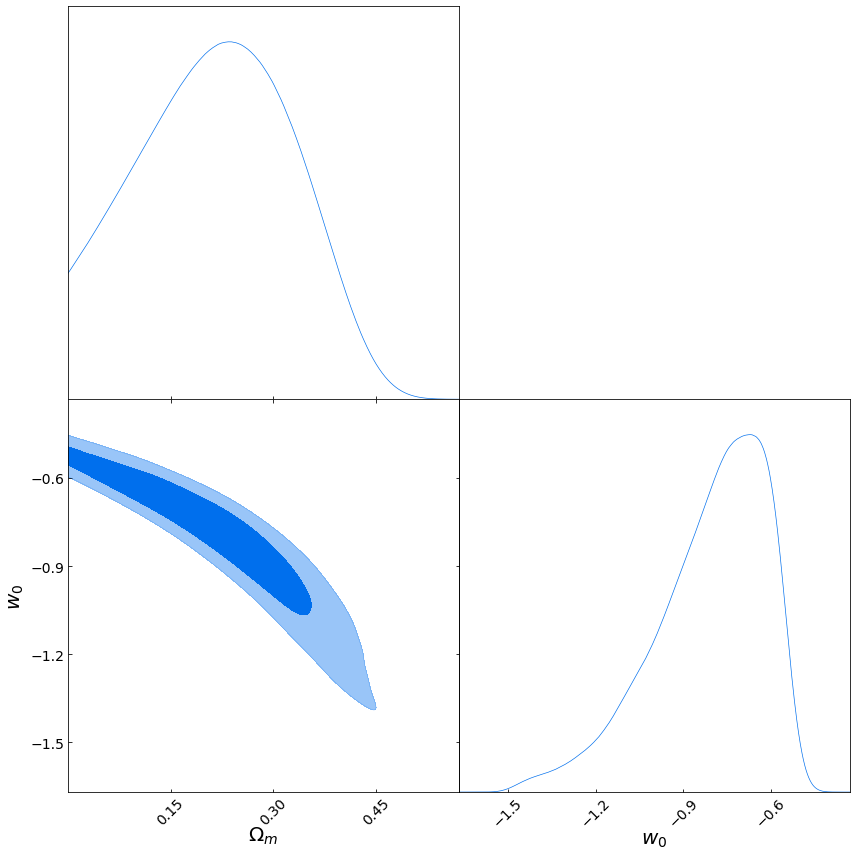

Population 32/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 5940 samples, validate on 660 samples
Epoch 1/100
5940/5940 [==============================] - 9s 2ms/step - loss: 1.3294 - val_loss: 1.3158
Epoch 2/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3284 - val_loss: 1.3165
Epoch 3/100
5940/5940 [==============================] - 10s 2ms/step - loss: 1.3297 - val_loss: 1.3245
Epoch 4/100
5940/5940 [==============================] - 10s 2ms/step - loss: 1.3353 - val_loss: 1.3166
Epoch 5/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3314 - val_loss: 1.3150
Epoch 6/100
5940/5940 [==============================] - 9s 2ms/step - loss: 1.3351 - val_loss: 1.3166
Epoch 7/100
5940/5940 [==============================] - 8s 1ms/step - loss: 1.3315 - val_loss: 1.3167
Epoch 8/100
5940/5940 [==============================] - 9s 2ms/step - loss: 1.3298 - val_loss: 1.3141
Epoch 9/100
5940/5940 [==========================

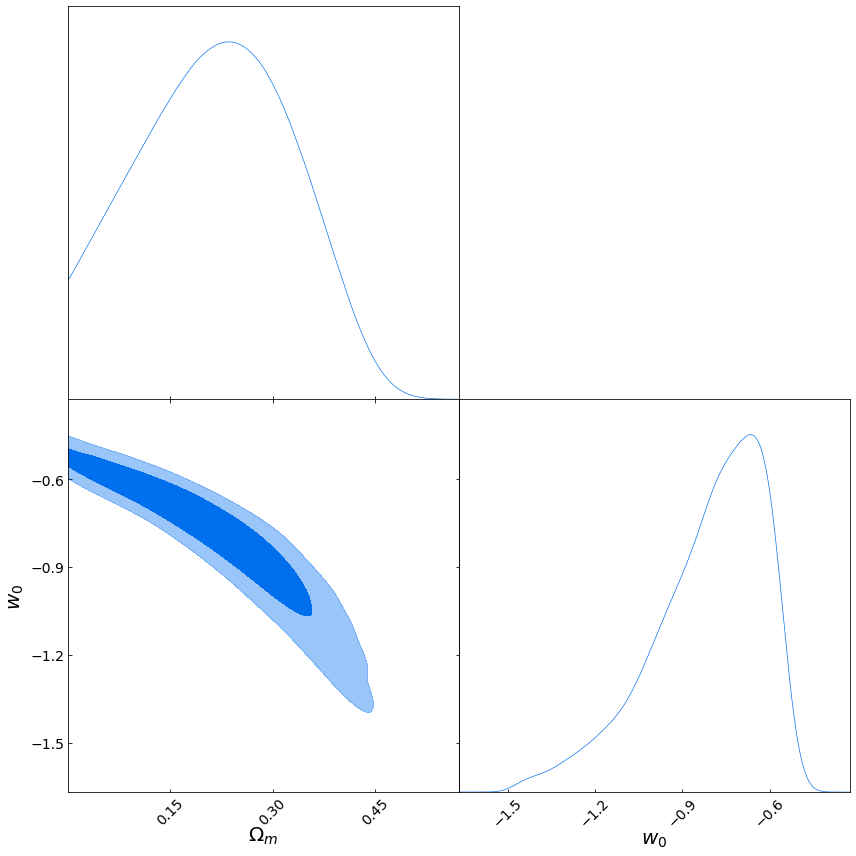

Population 33/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 6120 samples, validate on 680 samples
Epoch 1/100
6120/6120 [==============================] - 8s 1ms/step - loss: 1.3289 - val_loss: 1.2981
Epoch 2/100
6120/6120 [==============================] - 8s 1ms/step - loss: 1.3319 - val_loss: 1.2967
Epoch 3/100
6120/6120 [==============================] - 8s 1ms/step - loss: 1.3285 - val_loss: 1.2977
Epoch 4/100
6120/6120 [==============================] - 8s 1ms/step - loss: 1.3299 - val_loss: 1.2998
Epoch 5/100
6120/6120 [==============================] - 8s 1ms/step - loss: 1.3323 - val_loss: 1.2983
Epoch 6/100
6120/6120 [==============================] - 8s 1ms/step - loss: 1.3308 - val_loss: 1.2951
Epoch 7/100
6120/6120 [==============================] - 8s 1ms/step - loss: 1.3292 - val_loss: 1.2954
Epoch 8/100
6120/6120 [==============================] - 8s 1ms/step - loss: 1.3298 - val_loss: 1.2990
Epoch 9/100
6120/6120 [============================

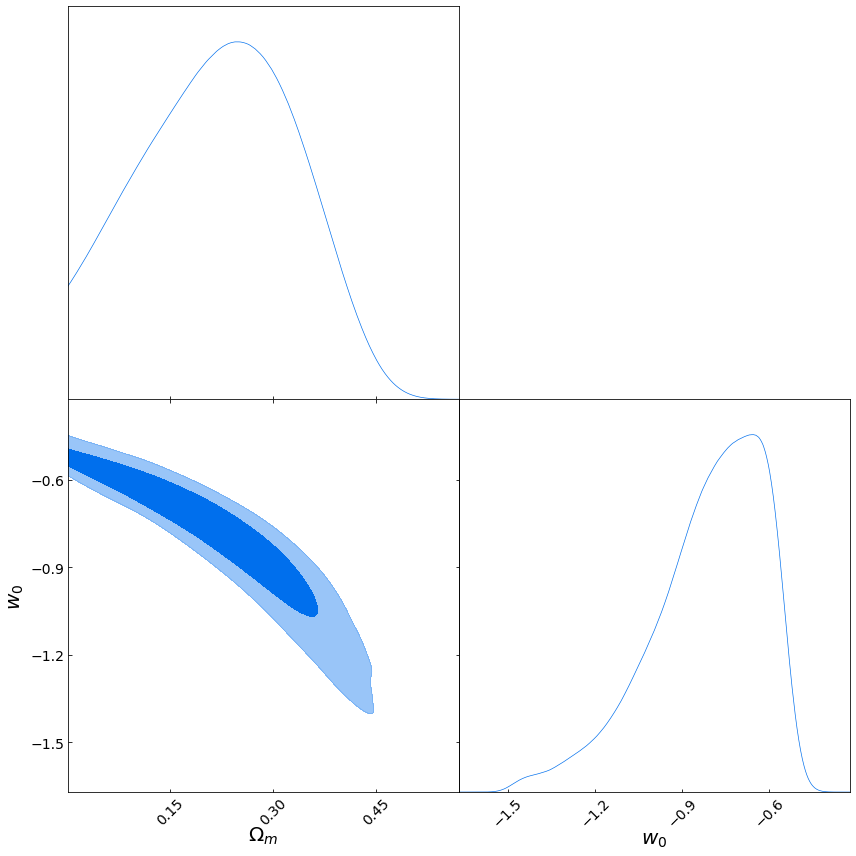

Population 34/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 6300 samples, validate on 700 samples
Epoch 1/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3305 - val_loss: 1.3197
Epoch 2/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3307 - val_loss: 1.3186
Epoch 3/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3320 - val_loss: 1.3288
Epoch 4/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3340 - val_loss: 1.3155
Epoch 5/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3331 - val_loss: 1.3384
Epoch 6/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3385 - val_loss: 1.3237
Epoch 7/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3340 - val_loss: 1.3210
Epoch 8/100
6300/6300 [==============================] - 9s 1ms/step - loss: 1.3353 - val_loss: 1.3258
Epoch 9/100
6300/6300 [============================

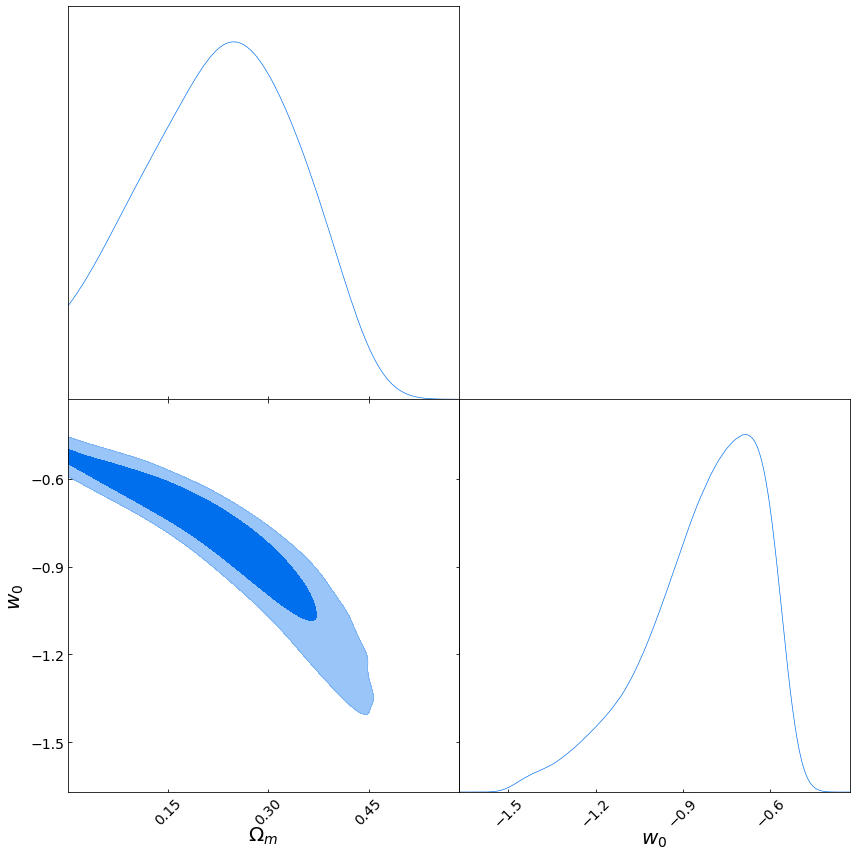

Population 35/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 6480 samples, validate on 720 samples
Epoch 1/100
6480/6480 [==============================] - 9s 1ms/step - loss: 1.3270 - val_loss: 1.3912
Epoch 2/100
6480/6480 [==============================] - 9s 1ms/step - loss: 1.3275 - val_loss: 1.3899
Epoch 3/100
6480/6480 [==============================] - 10s 1ms/step - loss: 1.3277 - val_loss: 1.3887
Epoch 4/100
6480/6480 [==============================] - 9s 1ms/step - loss: 1.3269 - val_loss: 1.4002
Epoch 5/100
6480/6480 [==============================] - 9s 1ms/step - loss: 1.3279 - val_loss: 1.3889
Epoch 6/100
6480/6480 [==============================] - 9s 1ms/step - loss: 1.3282 - val_loss: 1.3948
Epoch 7/100
6480/6480 [==============================] - 9s 1ms/step - loss: 1.3289 - val_loss: 1.3946
Epoch 8/100
6480/6480 [==============================] - 9s 1ms/step - loss: 1.3302 - val_loss: 1.3867
Epoch 9/100
6480/6480 [===========================

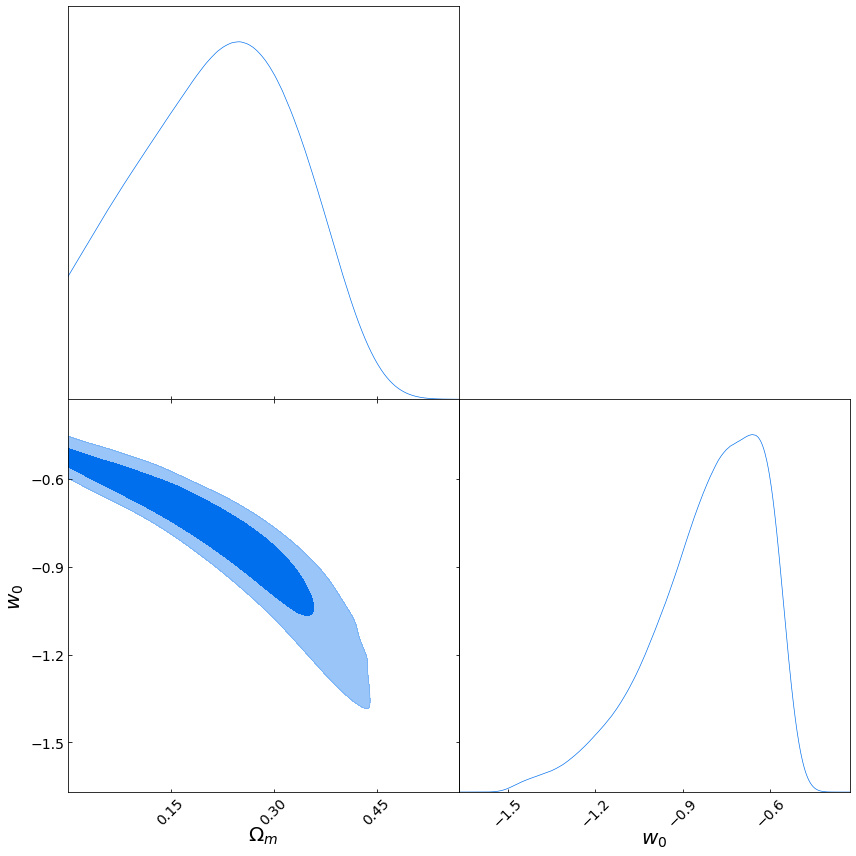

Population 36/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 6660 samples, validate on 740 samples
Epoch 1/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3276 - val_loss: 1.3770
Epoch 2/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3257 - val_loss: 1.3783
Epoch 3/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3262 - val_loss: 1.3787
Epoch 4/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3268 - val_loss: 1.3832
Epoch 5/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3298 - val_loss: 1.3780
Epoch 6/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3273 - val_loss: 1.3718
Epoch 7/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3261 - val_loss: 1.3735
Epoch 8/100
6660/6660 [==============================] - 9s 1ms/step - loss: 1.3254 - val_loss: 1.3775
Epoch 9/100
6660/6660 [============================

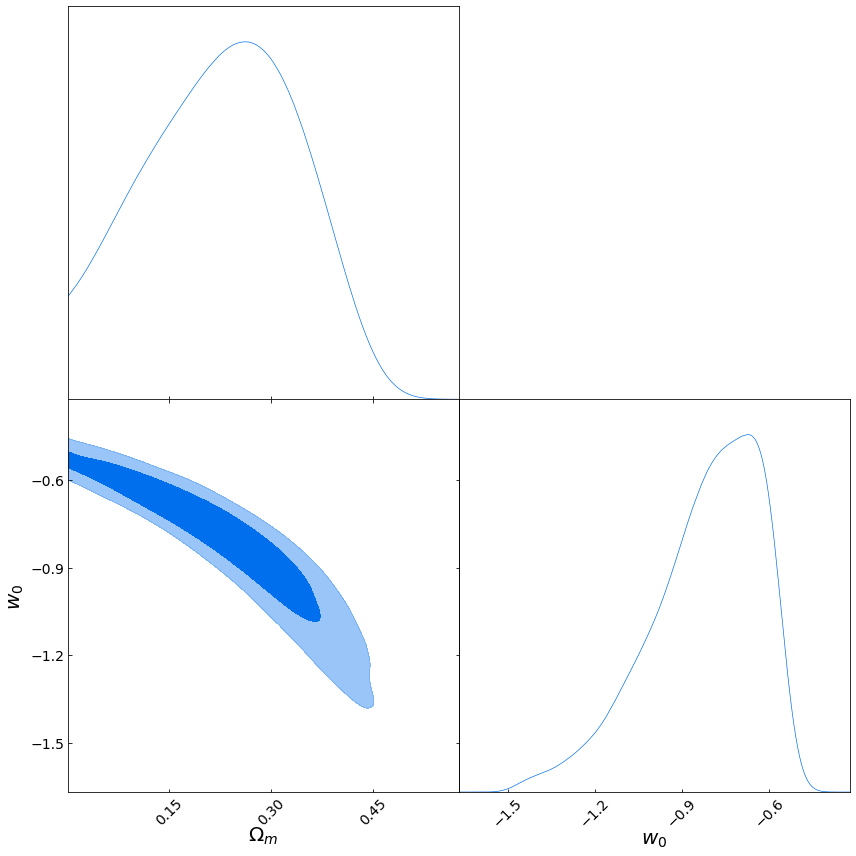

Population 37/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 6840 samples, validate on 760 samples
Epoch 1/100
6840/6840 [==============================] - 13s 2ms/step - loss: 1.3284 - val_loss: 1.3806
Epoch 2/100
6840/6840 [==============================] - 11s 2ms/step - loss: 1.3262 - val_loss: 1.3736
Epoch 3/100
6840/6840 [==============================] - 14s 2ms/step - loss: 1.3260 - val_loss: 1.3880
Epoch 4/100
6840/6840 [==============================] - 11s 2ms/step - loss: 1.3290 - val_loss: 1.3752
Epoch 5/100
6840/6840 [==============================] - 11s 2ms/step - loss: 1.3241 - val_loss: 1.3794
Epoch 6/100
6840/6840 [==============================] - 11s 2ms/step - loss: 1.3283 - val_loss: 1.3789
Epoch 7/100
6840/6840 [==============================] - 11s 2ms/step - loss: 1.3274 - val_loss: 1.3798
Epoch 8/100
6840/6840 [==============================] - 11s 2ms/step - loss: 1.3280 - val_loss: 1.3701
Epoch 9/100
6840/6840 [====================

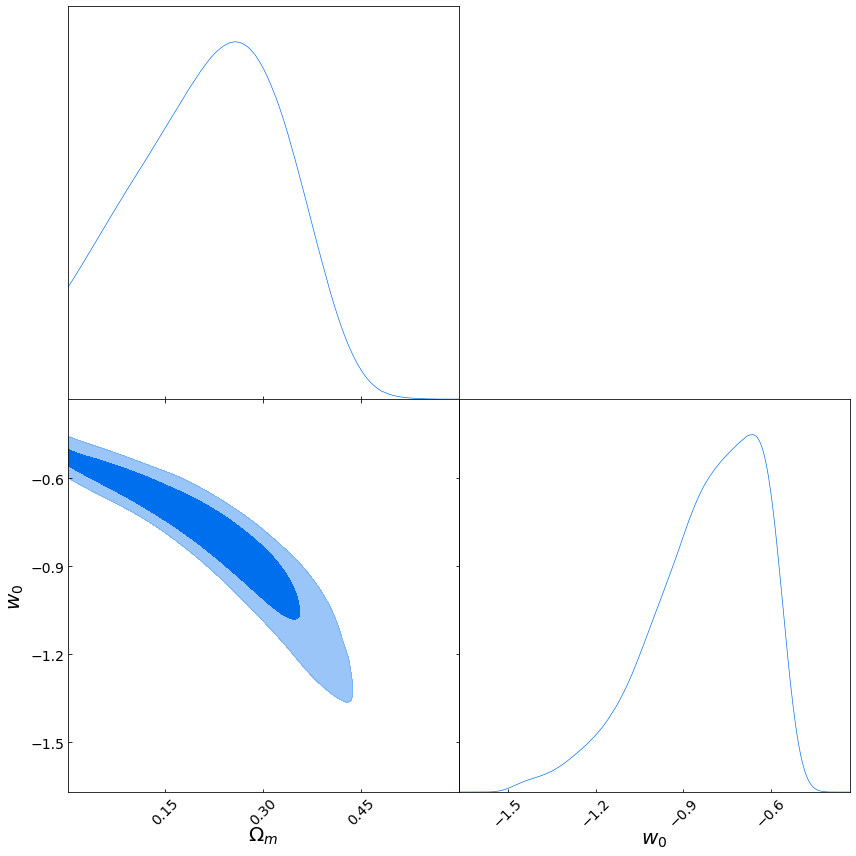

Population 38/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 7020 samples, validate on 780 samples
Epoch 1/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3300 - val_loss: 1.3540
Epoch 2/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3289 - val_loss: 1.3540
Epoch 3/100
7020/7020 [==============================] - 11s 2ms/step - loss: 1.3280 - val_loss: 1.3577
Epoch 4/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3274 - val_loss: 1.3546
Epoch 5/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3274 - val_loss: 1.3547
Epoch 6/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3266 - val_loss: 1.3554
Epoch 7/100
7020/7020 [==============================] - 10s 1ms/step - loss: 1.3277 - val_loss: 1.3592
Epoch 8/100
7020/7020 [==============================] - 11s 2ms/step - loss: 1.3271 - val_loss: 1.3557
Epoch 9/100
7020/7020 [====================

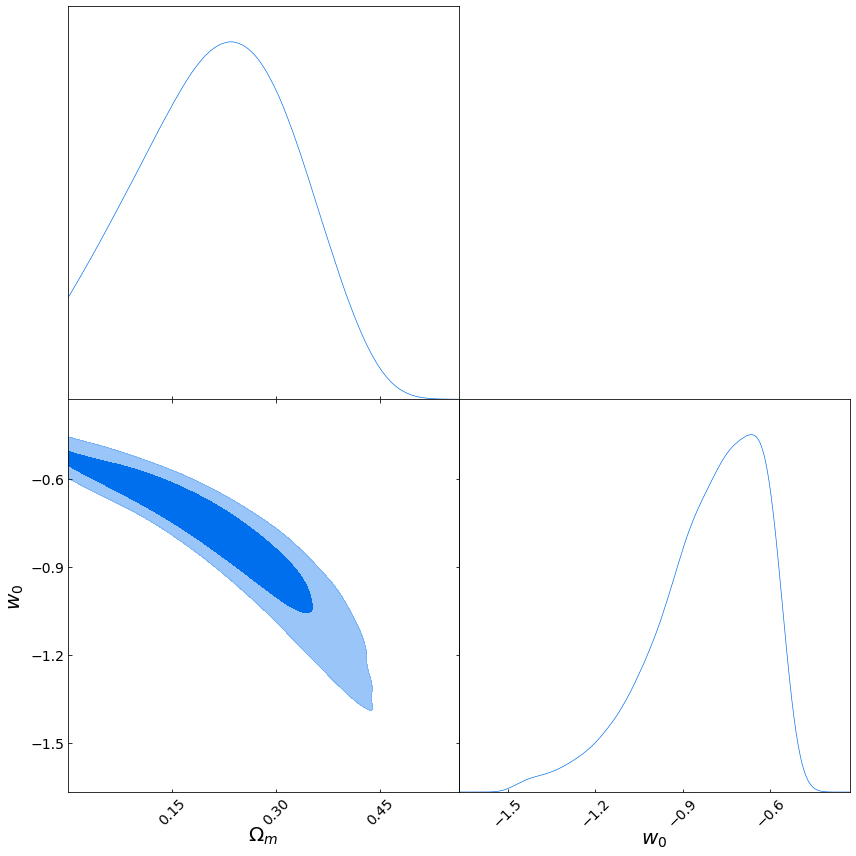

Population 39/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 11s 2ms/step - loss: 1.3390 - val_loss: 1.2948
Epoch 2/100
7200/7200 [==============================] - 11s 2ms/step - loss: 1.3350 - val_loss: 1.3016
Epoch 3/100
7200/7200 [==============================] - 11s 2ms/step - loss: 1.3332 - val_loss: 1.2982
Epoch 4/100
7200/7200 [==============================] - 12s 2ms/step - loss: 1.3362 - val_loss: 1.2949
Epoch 5/100
7200/7200 [==============================] - 11s 2ms/step - loss: 1.3344 - val_loss: 1.2964
Epoch 6/100
7200/7200 [==============================] - 11s 1ms/step - loss: 1.3339 - val_loss: 1.2969
Epoch 7/100
7200/7200 [==============================] - 14s 2ms/step - loss: 1.3338 - val_loss: 1.2988
Epoch 8/100
7200/7200 [==============================] - 16s 2ms/step - loss: 1.3359 - val_loss: 1.2934
Epoch 9/100
7200/7200 [====================

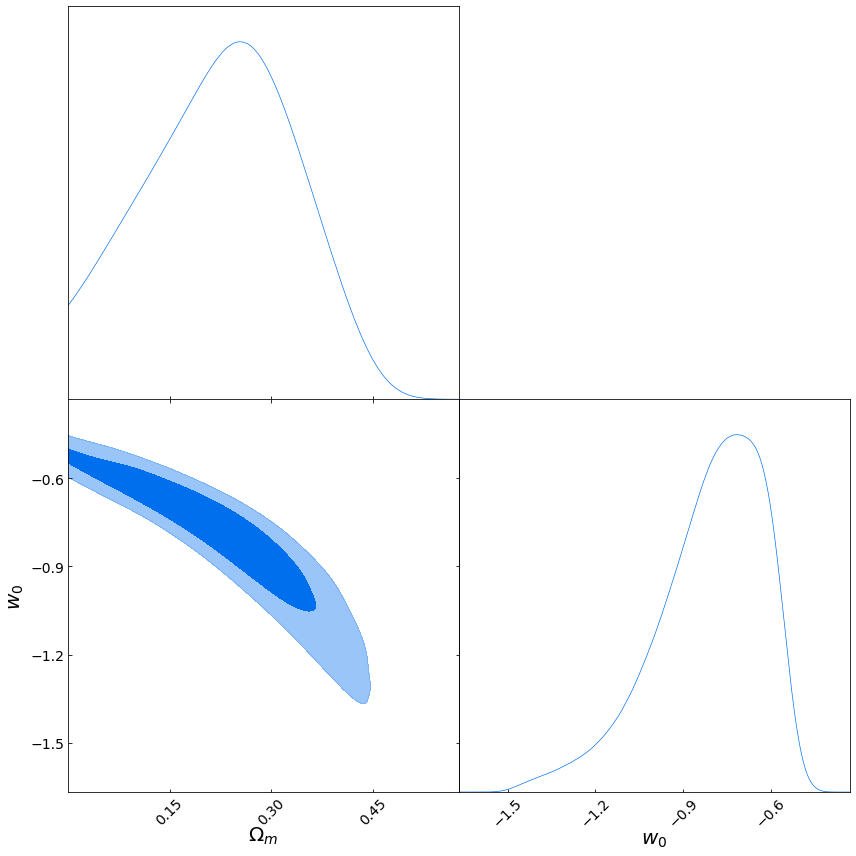

Population 40/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 7380 samples, validate on 820 samples
Epoch 1/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3328 - val_loss: 1.3448
Epoch 2/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3336 - val_loss: 1.3385
Epoch 3/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3346 - val_loss: 1.3381
Epoch 4/100
7380/7380 [==============================] - 11s 1ms/step - loss: 1.3356 - val_loss: 1.3435
Epoch 5/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3300 - val_loss: 1.3393
Epoch 6/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3320 - val_loss: 1.3369
Epoch 7/100
7380/7380 [==============================] - 10s 1ms/step - loss: 1.3324 - val_loss: 1.3345
Epoch 8/100
7380/7380 [==============================] - 11s 1ms/step - loss: 1.3300 - val_loss: 1.3332
Epoch 9/100
7380/7380 [====================

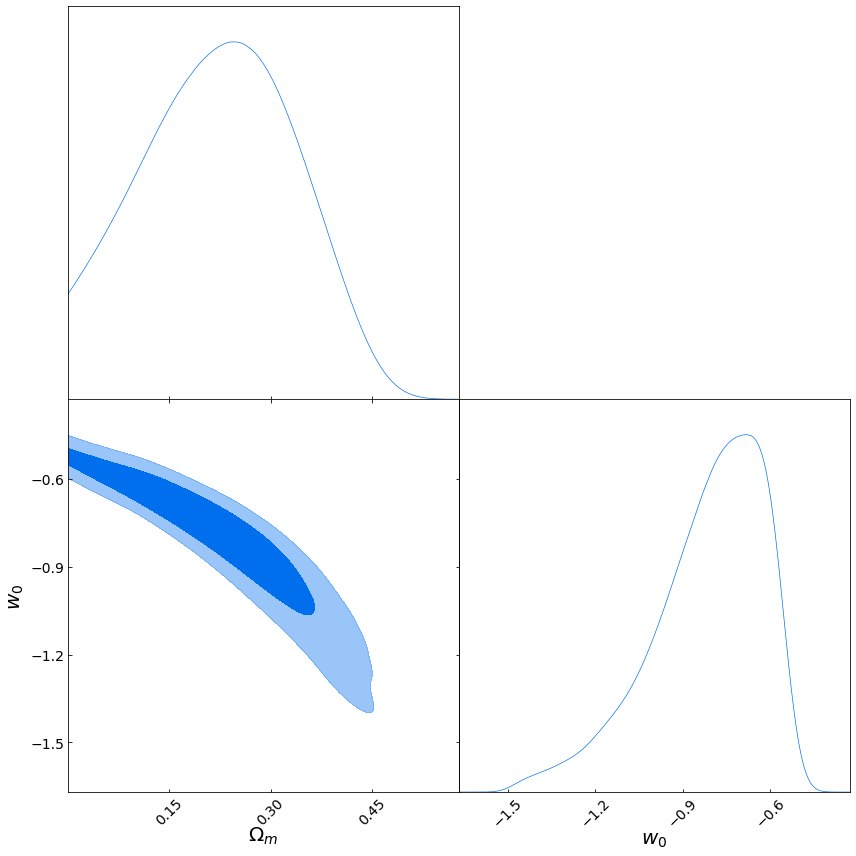

Population 41/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 7560 samples, validate on 840 samples
Epoch 1/100
7560/7560 [==============================] - 12s 2ms/step - loss: 1.3306 - val_loss: 1.3647
Epoch 2/100
7560/7560 [==============================] - 13s 2ms/step - loss: 1.3288 - val_loss: 1.3542
Epoch 3/100
7560/7560 [==============================] - 15s 2ms/step - loss: 1.3281 - val_loss: 1.3579
Epoch 4/100
7560/7560 [==============================] - 13s 2ms/step - loss: 1.3302 - val_loss: 1.3556
Epoch 5/100
7560/7560 [==============================] - 14s 2ms/step - loss: 1.3296 - val_loss: 1.3536
Epoch 6/100
7560/7560 [==============================] - 11s 1ms/step - loss: 1.3301 - val_loss: 1.3649
Epoch 7/100
7560/7560 [==============================] - 12s 2ms/step - loss: 1.3303 - val_loss: 1.3626
Epoch 8/100
7560/7560 [==============================] - 10s 1ms/step - loss: 1.3298 - val_loss: 1.3569
Epoch 9/100
7560/7560 [====================

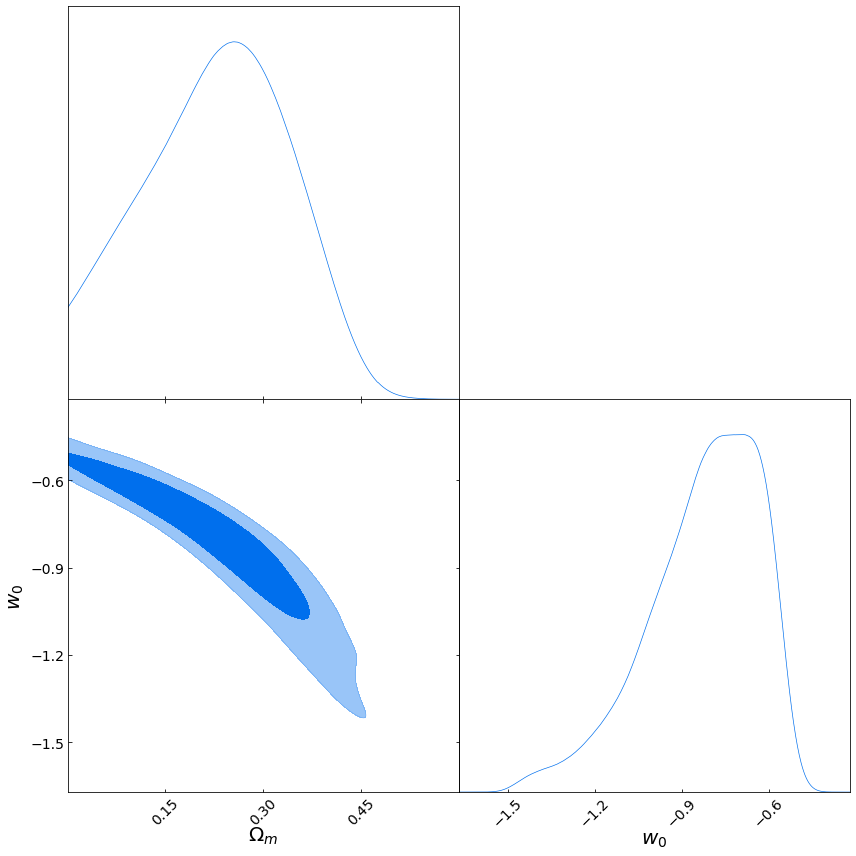

Population 42/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 7740 samples, validate on 860 samples
Epoch 1/100
7740/7740 [==============================] - 12s 2ms/step - loss: 1.3286 - val_loss: 1.3416
Epoch 2/100
7740/7740 [==============================] - 12s 2ms/step - loss: 1.3297 - val_loss: 1.3458
Epoch 3/100
7740/7740 [==============================] - 12s 2ms/step - loss: 1.3316 - val_loss: 1.3433
Epoch 4/100
7740/7740 [==============================] - 11s 1ms/step - loss: 1.3281 - val_loss: 1.3401
Epoch 5/100
7740/7740 [==============================] - 12s 2ms/step - loss: 1.3277 - val_loss: 1.3424
Epoch 6/100
7740/7740 [==============================] - 12s 2ms/step - loss: 1.3272 - val_loss: 1.3430
Epoch 7/100
7740/7740 [==============================] - 12s 2ms/step - loss: 1.3293 - val_loss: 1.3439
Epoch 8/100
7740/7740 [==============================] - 12s 2ms/step - loss: 1.3296 - val_loss: 1.3418
Epoch 9/100
7740/7740 [====================

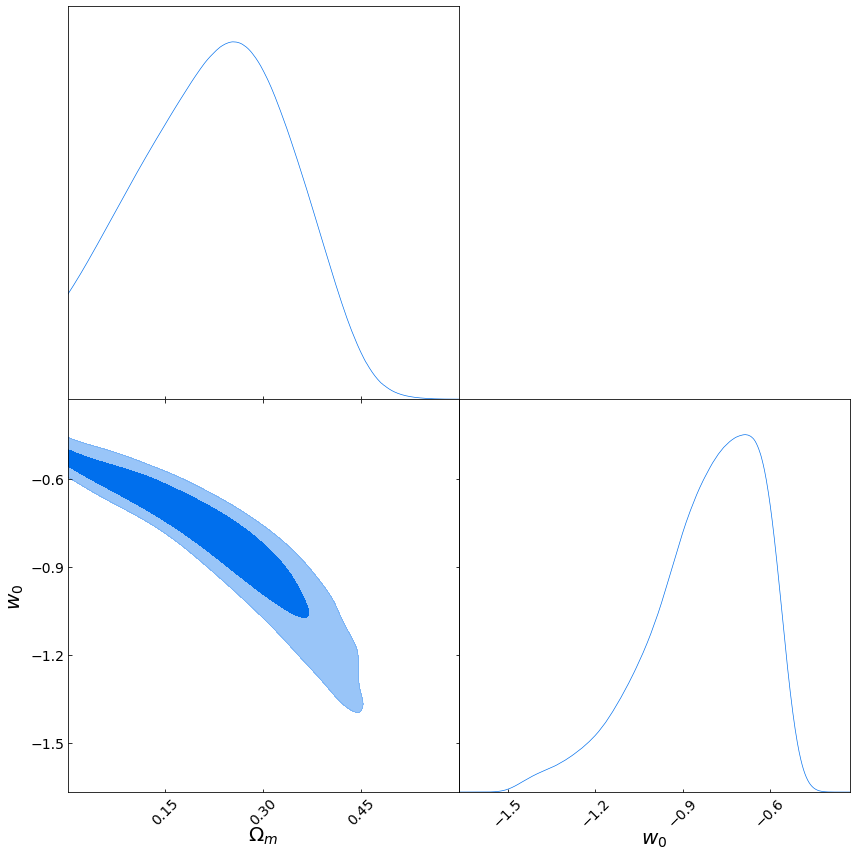

Population 43/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 7920 samples, validate on 880 samples
Epoch 1/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3297 - val_loss: 1.3538
Epoch 2/100
7920/7920 [==============================] - 11s 1ms/step - loss: 1.3286 - val_loss: 1.3534
Epoch 3/100
7920/7920 [==============================] - 11s 1ms/step - loss: 1.3279 - val_loss: 1.3556
Epoch 4/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3297 - val_loss: 1.3572
Epoch 5/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3292 - val_loss: 1.3568
Epoch 6/100
7920/7920 [==============================] - 11s 1ms/step - loss: 1.3296 - val_loss: 1.3530
Epoch 7/100
7920/7920 [==============================] - 11s 1ms/step - loss: 1.3303 - val_loss: 1.3631
Epoch 8/100
7920/7920 [==============================] - 10s 1ms/step - loss: 1.3349 - val_loss: 1.3521
Epoch 9/100
7920/7920 [====================

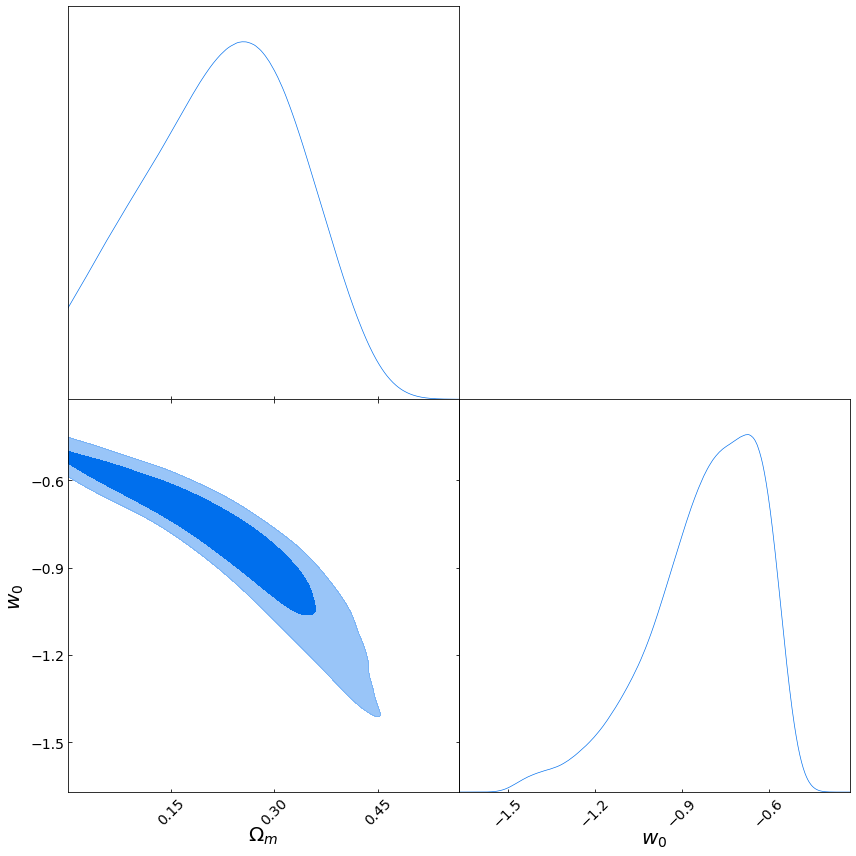

Population 44/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 8100 samples, validate on 900 samples
Epoch 1/100
8100/8100 [==============================] - 13s 2ms/step - loss: 1.3282 - val_loss: 1.3575
Epoch 2/100
8100/8100 [==============================] - 12s 1ms/step - loss: 1.3286 - val_loss: 1.3652
Epoch 3/100
8100/8100 [==============================] - 13s 2ms/step - loss: 1.3275 - val_loss: 1.3562
Epoch 4/100
8100/8100 [==============================] - 21s 3ms/step - loss: 1.3298 - val_loss: 1.3559
Epoch 5/100
8100/8100 [==============================] - 22s 3ms/step - loss: 1.3282 - val_loss: 1.3548
Epoch 6/100
8100/8100 [==============================] - 14s 2ms/step - loss: 1.3308 - val_loss: 1.3640
Epoch 7/100
8100/8100 [==============================] - 13s 2ms/step - loss: 1.3314 - val_loss: 1.3711
Epoch 8/100
8100/8100 [==============================] - 14s 2ms/step - loss: 1.3341 - val_loss: 1.3594
Epoch 9/100
8100/8100 [====================

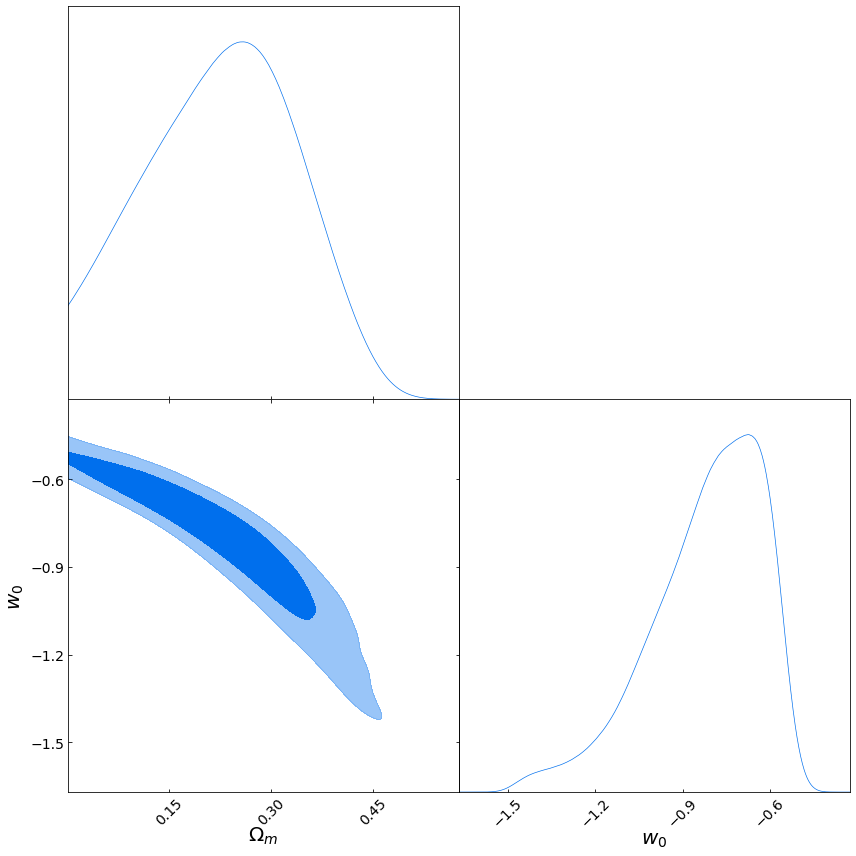

Population 45/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 8280 samples, validate on 920 samples
Epoch 1/100
8280/8280 [==============================] - 11s 1ms/step - loss: 1.3335 - val_loss: 1.3462
Epoch 2/100
8280/8280 [==============================] - 12s 1ms/step - loss: 1.3289 - val_loss: 1.3430
Epoch 3/100
8280/8280 [==============================] - 12s 1ms/step - loss: 1.3299 - val_loss: 1.3445
Epoch 4/100
8280/8280 [==============================] - 12s 1ms/step - loss: 1.3315 - val_loss: 1.3510
Epoch 5/100
8280/8280 [==============================] - 13s 2ms/step - loss: 1.3335 - val_loss: 1.3564
Epoch 6/100
8280/8280 [==============================] - 16s 2ms/step - loss: 1.3347 - val_loss: 1.3450
Epoch 7/100
8280/8280 [==============================] - 11s 1ms/step - loss: 1.3313 - val_loss: 1.3442
Epoch 8/100
8280/8280 [==============================] - 10s 1ms/step - loss: 1.3361 - val_loss: 1.3626
Epoch 9/100
8280/8280 [====================

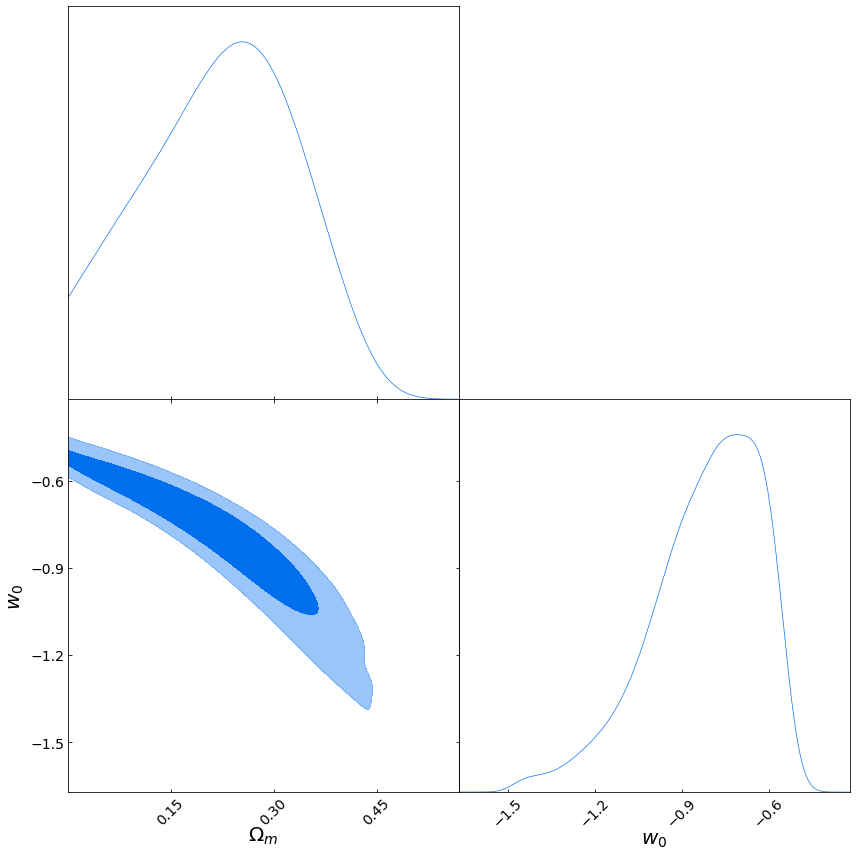

Population 46/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 8460 samples, validate on 940 samples
Epoch 1/100
8460/8460 [==============================] - 13s 2ms/step - loss: 1.3343 - val_loss: 1.3331
Epoch 2/100
8460/8460 [==============================] - 14s 2ms/step - loss: 1.3325 - val_loss: 1.3210
Epoch 3/100
8460/8460 [==============================] - 13s 2ms/step - loss: 1.3319 - val_loss: 1.3242
Epoch 4/100
8460/8460 [==============================] - 16s 2ms/step - loss: 1.3308 - val_loss: 1.3233
Epoch 5/100
8460/8460 [==============================] - 13s 2ms/step - loss: 1.3306 - val_loss: 1.3253
Epoch 6/100
8460/8460 [==============================] - 16s 2ms/step - loss: 1.3319 - val_loss: 1.3224
Epoch 7/100
8460/8460 [==============================] - 21s 2ms/step - loss: 1.3311 - val_loss: 1.3272
Epoch 8/100
8460/8460 [==============================] - 32s 4ms/step - loss: 1.3311 - val_loss: 1.3318
Epoch 9/100
8460/8460 [====================

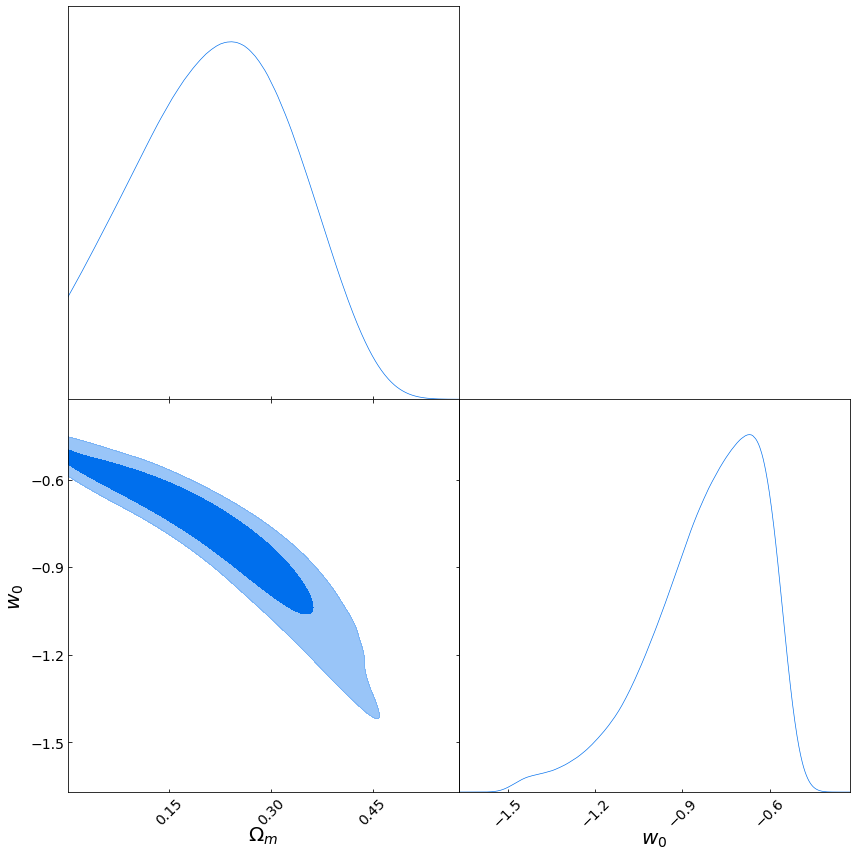

Population 47/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 8640 samples, validate on 960 samples
Epoch 1/100
8640/8640 [==============================] - 13s 2ms/step - loss: 1.3283 - val_loss: 1.3680
Epoch 2/100
8640/8640 [==============================] - 13s 2ms/step - loss: 1.3280 - val_loss: 1.3715
Epoch 3/100
8640/8640 [==============================] - 13s 2ms/step - loss: 1.3293 - val_loss: 1.3656
Epoch 4/100
8640/8640 [==============================] - 14s 2ms/step - loss: 1.3288 - val_loss: 1.3614
Epoch 5/100
8640/8640 [==============================] - 13s 1ms/step - loss: 1.3268 - val_loss: 1.3683
Epoch 6/100
8640/8640 [==============================] - 13s 1ms/step - loss: 1.3276 - val_loss: 1.3623
Epoch 7/100
8640/8640 [==============================] - 13s 2ms/step - loss: 1.3266 - val_loss: 1.3631
Epoch 8/100
8640/8640 [==============================] - 13s 2ms/step - loss: 1.3284 - val_loss: 1.3668
Epoch 9/100
8640/8640 [====================

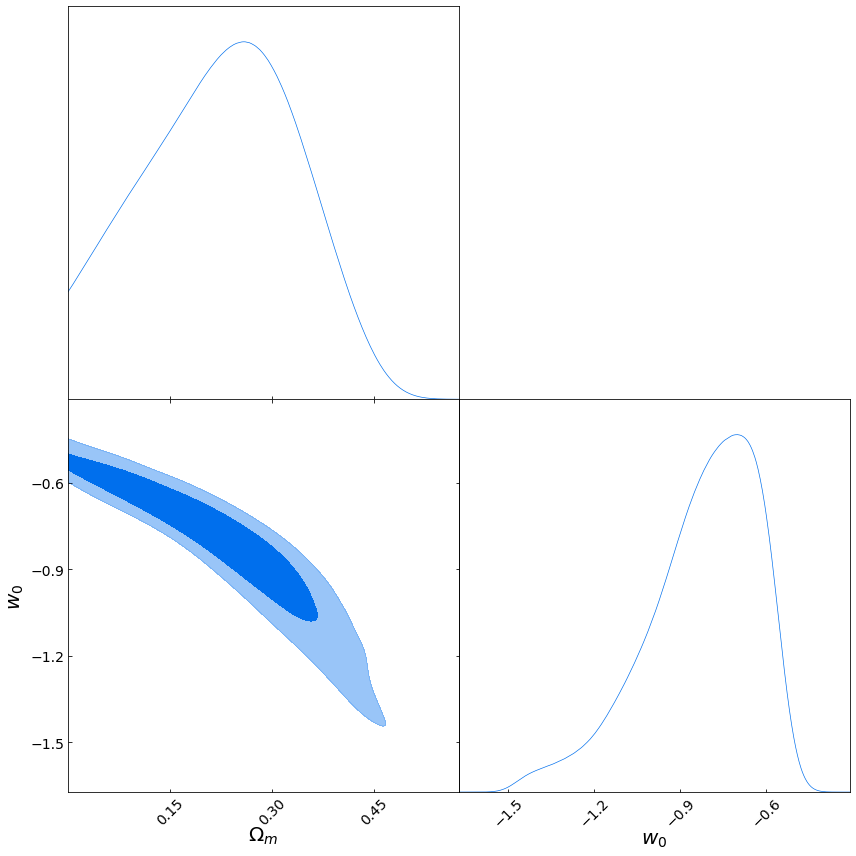

Population 48/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 8820 samples, validate on 980 samples
Epoch 1/100
8820/8820 [==============================] - 12s 1ms/step - loss: 1.3309 - val_loss: 1.3717
Epoch 2/100
8820/8820 [==============================] - 12s 1ms/step - loss: 1.3333 - val_loss: 1.3732
Epoch 3/100
8820/8820 [==============================] - 12s 1ms/step - loss: 1.3317 - val_loss: 1.3751
Epoch 4/100
8820/8820 [==============================] - 13s 1ms/step - loss: 1.3302 - val_loss: 1.3702
Epoch 5/100
8820/8820 [==============================] - 12s 1ms/step - loss: 1.3304 - val_loss: 1.3705
Epoch 6/100
8820/8820 [==============================] - 12s 1ms/step - loss: 1.3290 - val_loss: 1.3790
Epoch 7/100
8820/8820 [==============================] - 12s 1ms/step - loss: 1.3301 - val_loss: 1.3760
Epoch 8/100
8820/8820 [==============================] - 13s 1ms/step - loss: 1.3298 - val_loss: 1.3759
Epoch 9/100
8820/8820 [====================

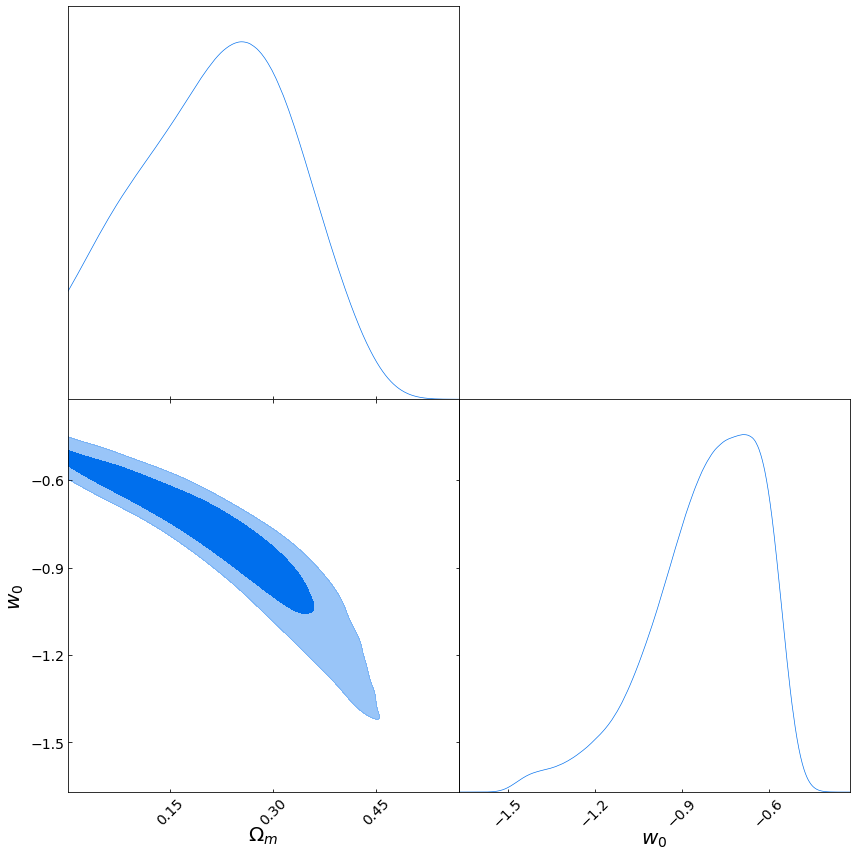

Population 49/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3300 - val_loss: 1.3761
Epoch 2/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3292 - val_loss: 1.3784
Epoch 3/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3293 - val_loss: 1.3751
Epoch 4/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3307 - val_loss: 1.3773
Epoch 5/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3301 - val_loss: 1.3773
Epoch 6/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3328 - val_loss: 1.3898
Epoch 7/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3330 - val_loss: 1.3746
Epoch 8/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3306 - val_loss: 1.3751
Epoch 9/100
9000/9000 [===================

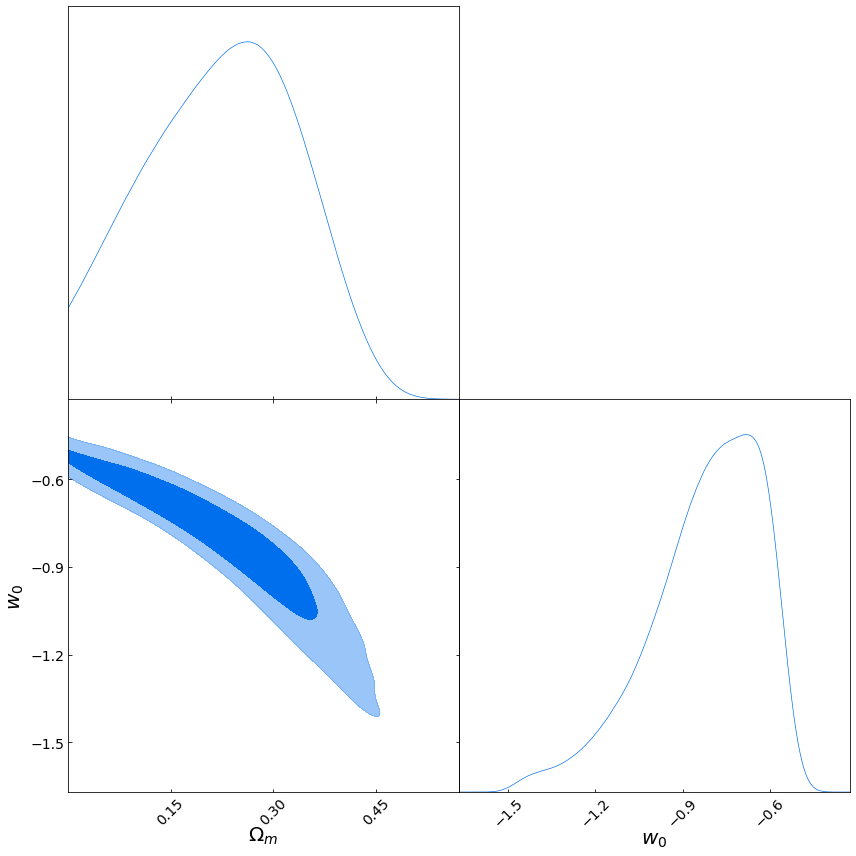

Population 50/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 9180 samples, validate on 1020 samples
Epoch 1/100
9180/9180 [==============================] - 13s 1ms/step - loss: 1.3304 - val_loss: 1.3828
Epoch 2/100
9180/9180 [==============================] - 13s 1ms/step - loss: 1.3288 - val_loss: 1.3832
Epoch 3/100
9180/9180 [==============================] - 14s 1ms/step - loss: 1.3279 - val_loss: 1.3882
Epoch 4/100
9180/9180 [==============================] - 13s 1ms/step - loss: 1.3311 - val_loss: 1.3910
Epoch 5/100
9180/9180 [==============================] - 14s 1ms/step - loss: 1.3291 - val_loss: 1.3851
Epoch 6/100
9180/9180 [==============================] - 13s 1ms/step - loss: 1.3303 - val_loss: 1.3851
Epoch 7/100
9180/9180 [==============================] - 13s 1ms/step - loss: 1.3294 - val_loss: 1.3862
Epoch 8/100
9180/9180 [==============================] - 13s 1ms/step - loss: 1.3306 - val_loss: 1.3833
Epoch 9/100
9180/9180 [===================

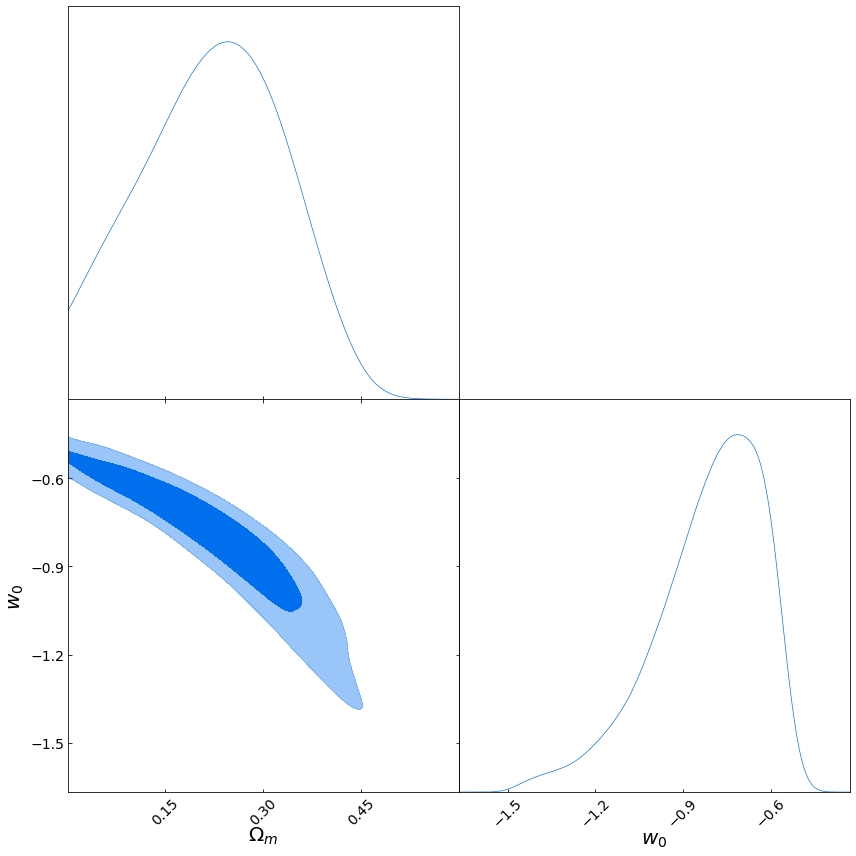

Population 51/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 9360 samples, validate on 1040 samples
Epoch 1/100
9360/9360 [==============================] - 12s 1ms/step - loss: 1.3290 - val_loss: 1.3850
Epoch 2/100
9360/9360 [==============================] - 12s 1ms/step - loss: 1.3302 - val_loss: 1.3887
Epoch 3/100
9360/9360 [==============================] - 13s 1ms/step - loss: 1.3299 - val_loss: 1.3914
Epoch 4/100
9360/9360 [==============================] - 13s 1ms/step - loss: 1.3299 - val_loss: 1.3846
Epoch 5/100
9360/9360 [==============================] - 13s 1ms/step - loss: 1.3297 - val_loss: 1.3847
Epoch 6/100
9360/9360 [==============================] - 13s 1ms/step - loss: 1.3291 - val_loss: 1.3838
Epoch 7/100
9360/9360 [==============================] - 13s 1ms/step - loss: 1.3294 - val_loss: 1.3856
Epoch 8/100
9360/9360 [==============================] - 13s 1ms/step - loss: 1.3291 - val_loss: 1.3850
Epoch 9/100
9360/9360 [===================

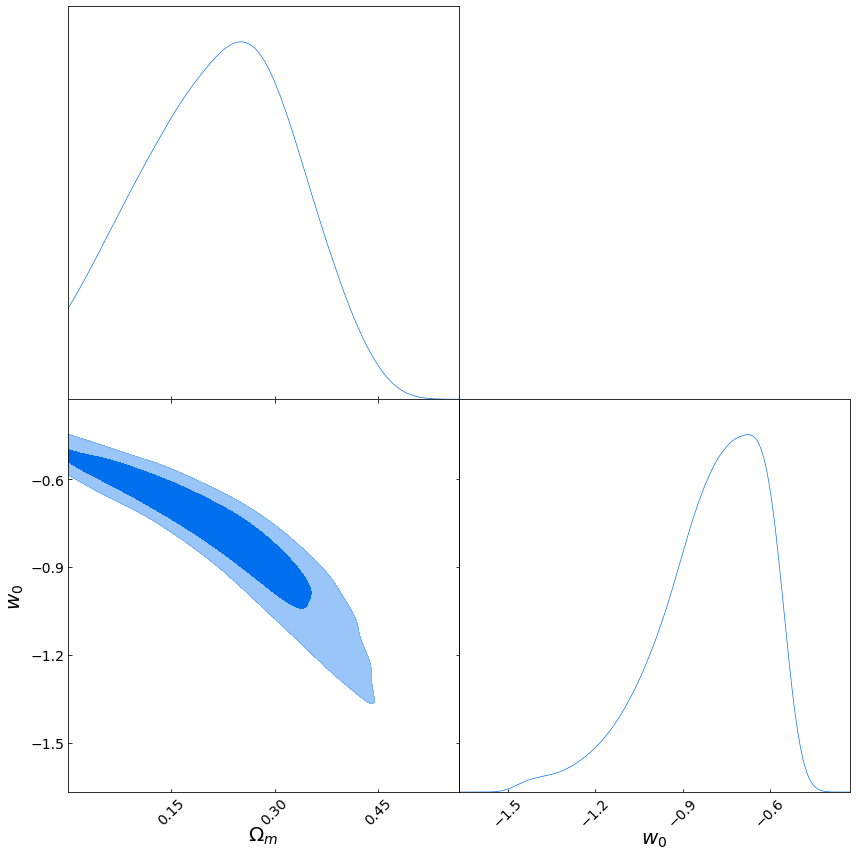

Population 52/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 9540 samples, validate on 1060 samples
Epoch 1/100
9540/9540 [==============================] - 18s 2ms/step - loss: 1.3311 - val_loss: 1.3597
Epoch 2/100
9540/9540 [==============================] - 16s 2ms/step - loss: 1.3306 - val_loss: 1.3578
Epoch 3/100
9540/9540 [==============================] - 16s 2ms/step - loss: 1.3316 - val_loss: 1.3553
Epoch 4/100
9540/9540 [==============================] - 15s 2ms/step - loss: 1.3345 - val_loss: 1.3686
Epoch 5/100
9540/9540 [==============================] - 16s 2ms/step - loss: 1.3322 - val_loss: 1.3568
Epoch 6/100
9540/9540 [==============================] - 16s 2ms/step - loss: 1.3331 - val_loss: 1.3547
Epoch 7/100
9540/9540 [==============================] - 16s 2ms/step - loss: 1.3325 - val_loss: 1.3589
Epoch 8/100
9540/9540 [==============================] - 16s 2ms/step - loss: 1.3308 - val_loss: 1.3583
Epoch 9/100
9540/9540 [===================

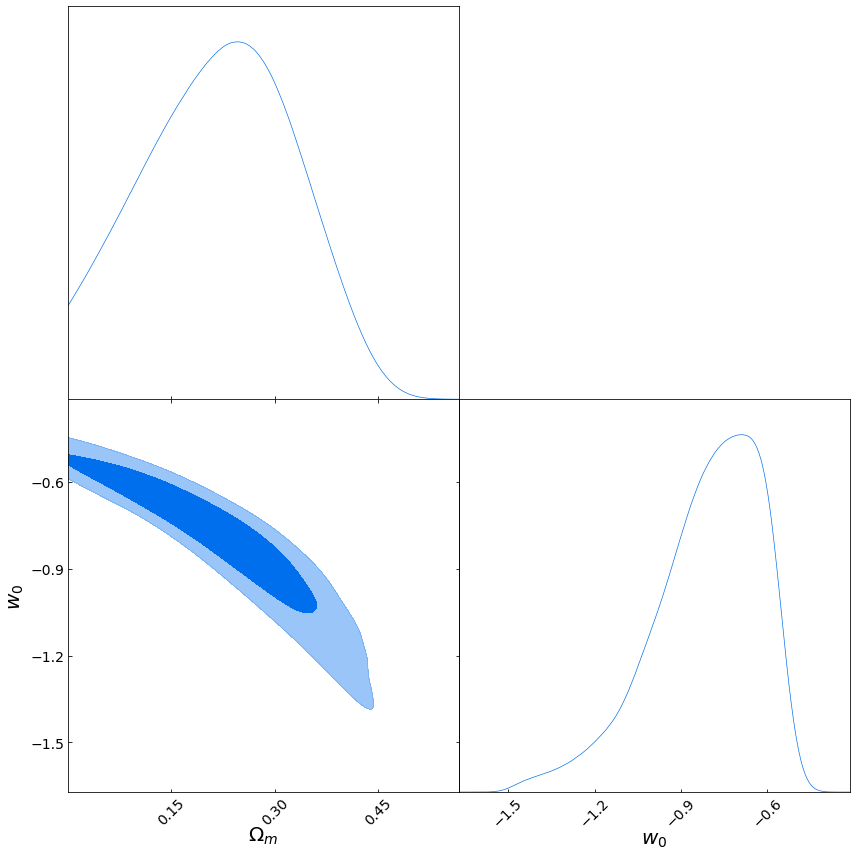

Population 53/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 9720 samples, validate on 1080 samples
Epoch 1/100
9720/9720 [==============================] - 16s 2ms/step - loss: 1.3317 - val_loss: 1.3705
Epoch 2/100
9720/9720 [==============================] - 15s 2ms/step - loss: 1.3330 - val_loss: 1.3722
Epoch 3/100
9720/9720 [==============================] - 15s 2ms/step - loss: 1.3328 - val_loss: 1.3691
Epoch 4/100
9720/9720 [==============================] - 15s 2ms/step - loss: 1.3307 - val_loss: 1.3686
Epoch 5/100
9720/9720 [==============================] - 16s 2ms/step - loss: 1.3305 - val_loss: 1.3669
Epoch 6/100
9720/9720 [==============================] - 16s 2ms/step - loss: 1.3316 - val_loss: 1.3753
Epoch 7/100
9720/9720 [==============================] - 16s 2ms/step - loss: 1.3311 - val_loss: 1.3689
Epoch 8/100
9720/9720 [==============================] - 16s 2ms/step - loss: 1.3312 - val_loss: 1.3717
Epoch 9/100
9720/9720 [===================

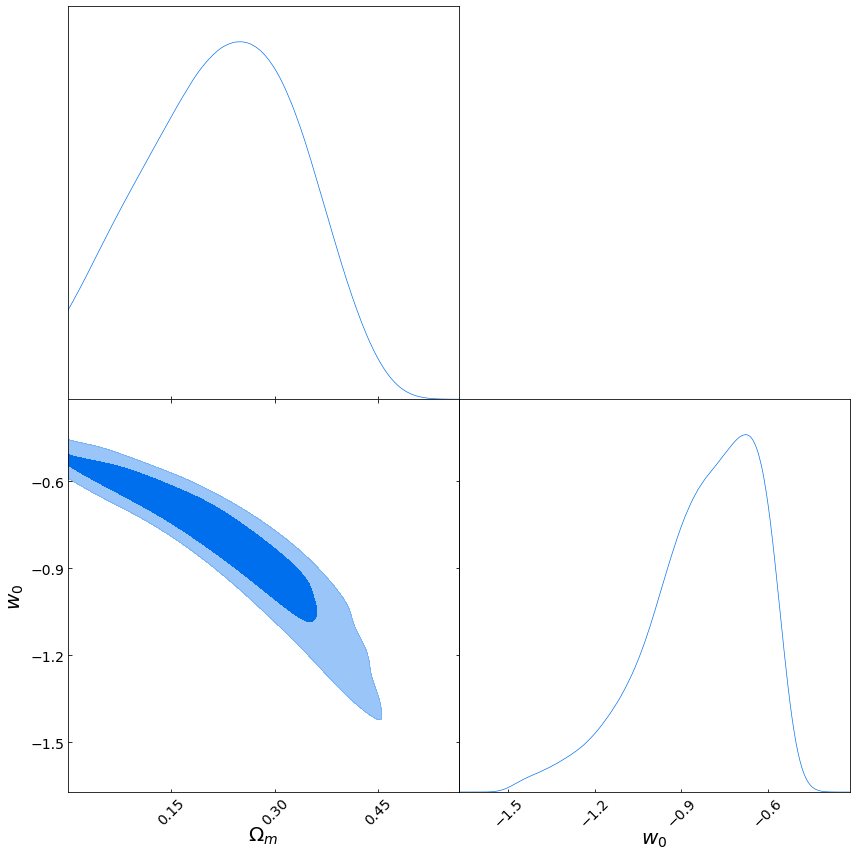

Population 54/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 9900 samples, validate on 1100 samples
Epoch 1/100
9900/9900 [==============================] - 12s 1ms/step - loss: 1.3341 - val_loss: 1.3623
Epoch 2/100
9900/9900 [==============================] - 12s 1ms/step - loss: 1.3343 - val_loss: 1.3522
Epoch 3/100
9900/9900 [==============================] - 12s 1ms/step - loss: 1.3327 - val_loss: 1.3533
Epoch 4/100
9900/9900 [==============================] - 12s 1ms/step - loss: 1.3341 - val_loss: 1.3615
Epoch 5/100
9900/9900 [==============================] - 12s 1ms/step - loss: 1.3363 - val_loss: 1.3660
Epoch 6/100
9900/9900 [==============================] - 12s 1ms/step - loss: 1.3356 - val_loss: 1.3518
Epoch 7/100
9900/9900 [==============================] - 12s 1ms/step - loss: 1.3337 - val_loss: 1.3546
Epoch 8/100
9900/9900 [==============================] - 12s 1ms/step - loss: 1.3337 - val_loss: 1.3526
Epoch 9/100
9900/9900 [===================

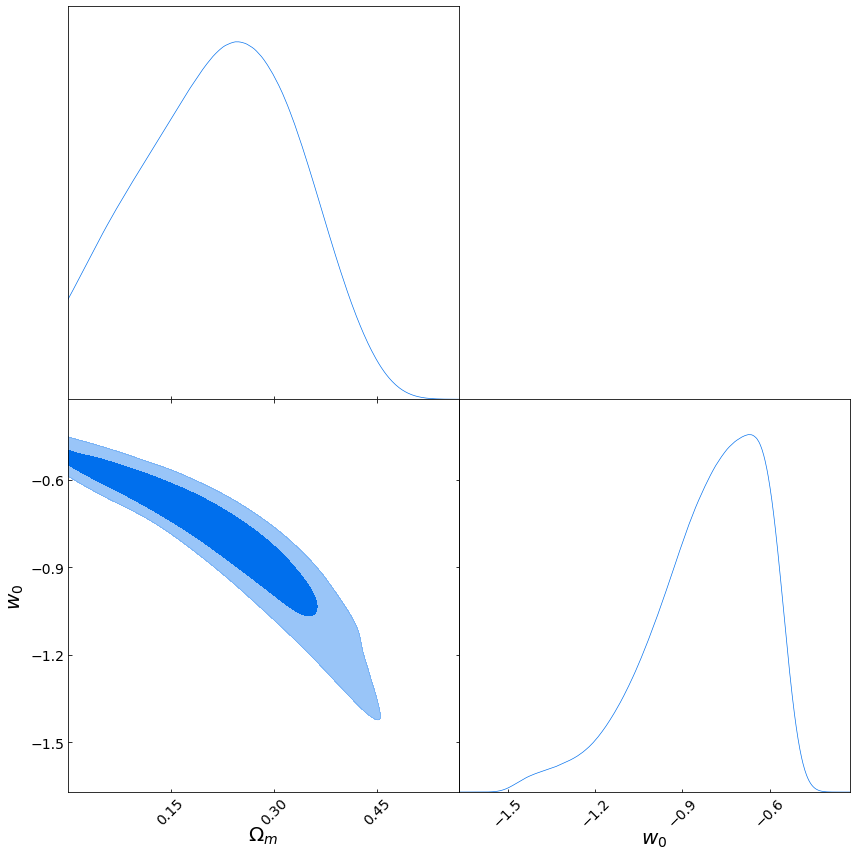

Population 55/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 10080 samples, validate on 1120 samples
Epoch 1/100
10080/10080 [==============================] - 15s 1ms/step - loss: 1.3319 - val_loss: 1.3399
Epoch 2/100
10080/10080 [==============================] - 16s 2ms/step - loss: 1.3334 - val_loss: 1.3380
Epoch 3/100
10080/10080 [==============================] - 26s 3ms/step - loss: 1.3356 - val_loss: 1.3377
Epoch 4/100
10080/10080 [==============================] - 13s 1ms/step - loss: 1.3340 - val_loss: 1.3395
Epoch 5/100
10080/10080 [==============================] - 13s 1ms/step - loss: 1.3325 - val_loss: 1.3404
Epoch 6/100
10080/10080 [==============================] - 13s 1ms/step - loss: 1.3326 - val_loss: 1.3380
Epoch 7/100
10080/10080 [==============================] - 12s 1ms/step - loss: 1.3343 - val_loss: 1.3427
Epoch 8/100
10080/10080 [==============================] - 12s 1ms/step - loss: 1.3367 - val_loss: 1.3436
Epoch 9/100
10080/10080 [

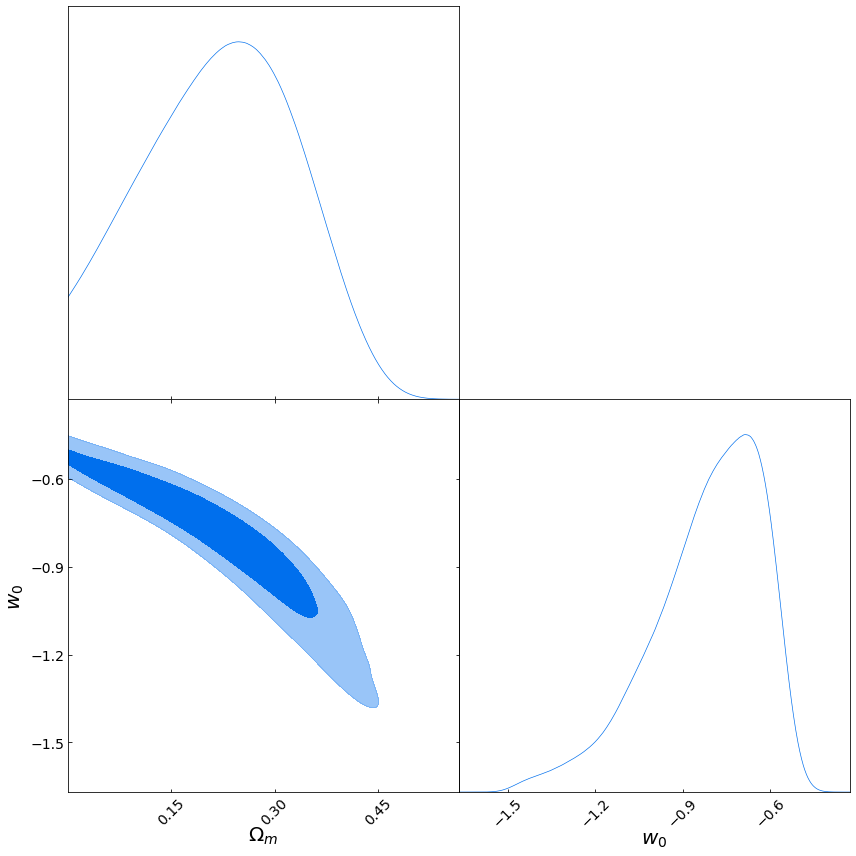

Population 56/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 10260 samples, validate on 1140 samples
Epoch 1/100
10260/10260 [==============================] - 13s 1ms/step - loss: 1.3375 - val_loss: 1.3179
Epoch 2/100
10260/10260 [==============================] - 13s 1ms/step - loss: 1.3350 - val_loss: 1.3169
Epoch 3/100
10260/10260 [==============================] - 13s 1ms/step - loss: 1.3347 - val_loss: 1.3180
Epoch 4/100
10260/10260 [==============================] - 13s 1ms/step - loss: 1.3368 - val_loss: 1.3183
Epoch 5/100
10260/10260 [==============================] - 13s 1ms/step - loss: 1.3365 - val_loss: 1.3203
Epoch 6/100
10260/10260 [==============================] - 13s 1ms/step - loss: 1.3372 - val_loss: 1.3191
Epoch 7/100
10260/10260 [==============================] - 13s 1ms/step - loss: 1.3345 - val_loss: 1.3178
Epoch 8/100
10260/10260 [==============================] - 13s 1ms/step - loss: 1.3371 - val_loss: 1.3179
Epoch 9/100
10260/10260 [

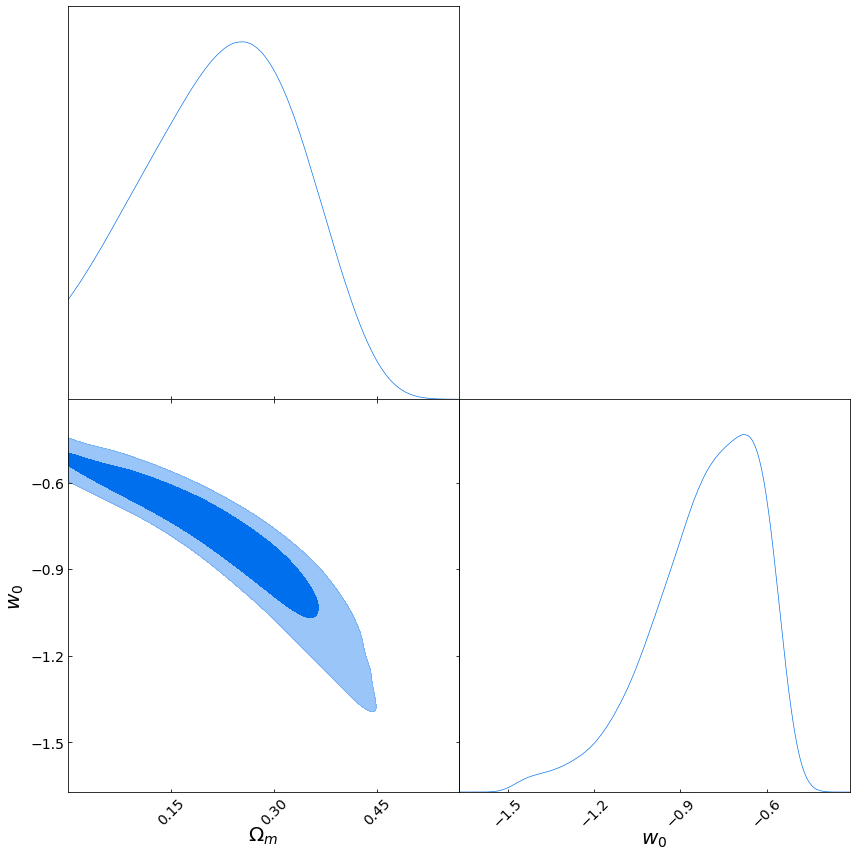

Population 57/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 10440 samples, validate on 1160 samples
Epoch 1/100
10440/10440 [==============================] - 13s 1ms/step - loss: 1.3317 - val_loss: 1.3183
Epoch 2/100
10440/10440 [==============================] - 13s 1ms/step - loss: 1.3322 - val_loss: 1.3200
Epoch 3/100
10440/10440 [==============================] - 13s 1ms/step - loss: 1.3350 - val_loss: 1.3194
Epoch 4/100
10440/10440 [==============================] - 13s 1ms/step - loss: 1.3355 - val_loss: 1.3276
Epoch 5/100
10440/10440 [==============================] - 13s 1ms/step - loss: 1.3342 - val_loss: 1.3193
Epoch 6/100
10440/10440 [==============================] - 13s 1ms/step - loss: 1.3335 - val_loss: 1.3200
Epoch 7/100
10440/10440 [==============================] - 13s 1ms/step - loss: 1.3341 - val_loss: 1.3255
Epoch 8/100
10440/10440 [==============================] - 13s 1ms/step - loss: 1.3337 - val_loss: 1.3227
Epoch 9/100
10440/10440 [

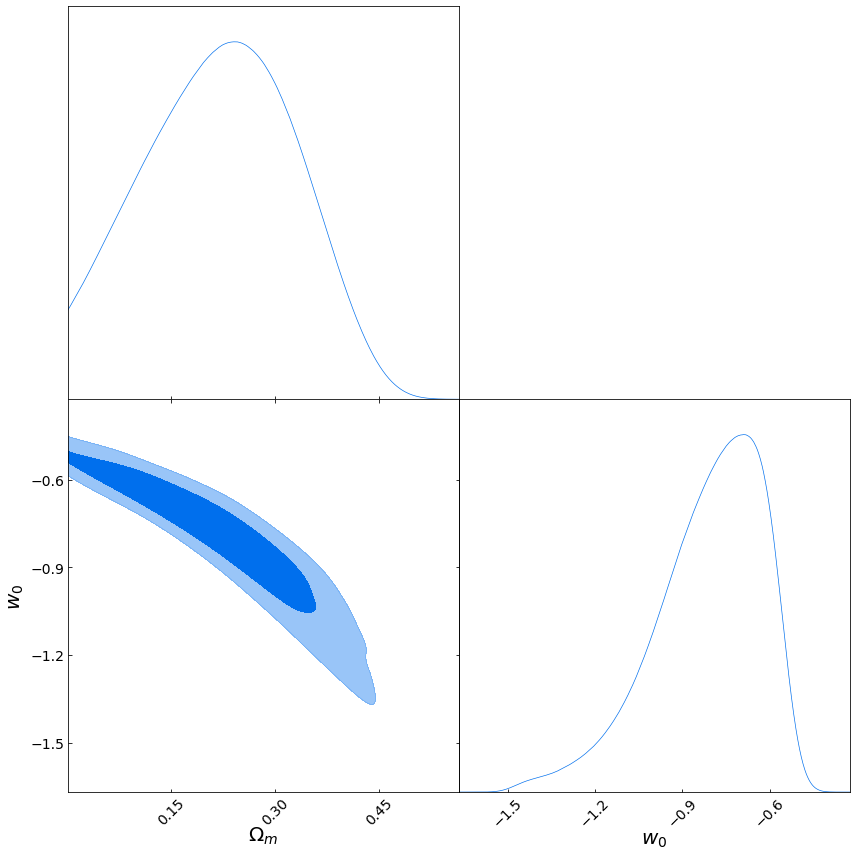

Population 58/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 10620 samples, validate on 1180 samples
Epoch 1/100
10620/10620 [==============================] - 13s 1ms/step - loss: 1.3306 - val_loss: 1.3459
Epoch 2/100
10620/10620 [==============================] - 13s 1ms/step - loss: 1.3332 - val_loss: 1.3358
Epoch 3/100
10620/10620 [==============================] - 13s 1ms/step - loss: 1.3323 - val_loss: 1.3404
Epoch 4/100
10620/10620 [==============================] - 13s 1ms/step - loss: 1.3348 - val_loss: 1.3404
Epoch 5/100
10620/10620 [==============================] - 13s 1ms/step - loss: 1.3321 - val_loss: 1.3357
Epoch 6/100
10620/10620 [==============================] - 13s 1ms/step - loss: 1.3318 - val_loss: 1.3393
Epoch 7/100
10620/10620 [==============================] - 13s 1ms/step - loss: 1.3314 - val_loss: 1.3360
Epoch 8/100
10620/10620 [==============================] - 13s 1ms/step - loss: 1.3321 - val_loss: 1.3408
Epoch 9/100
10620/10620 [

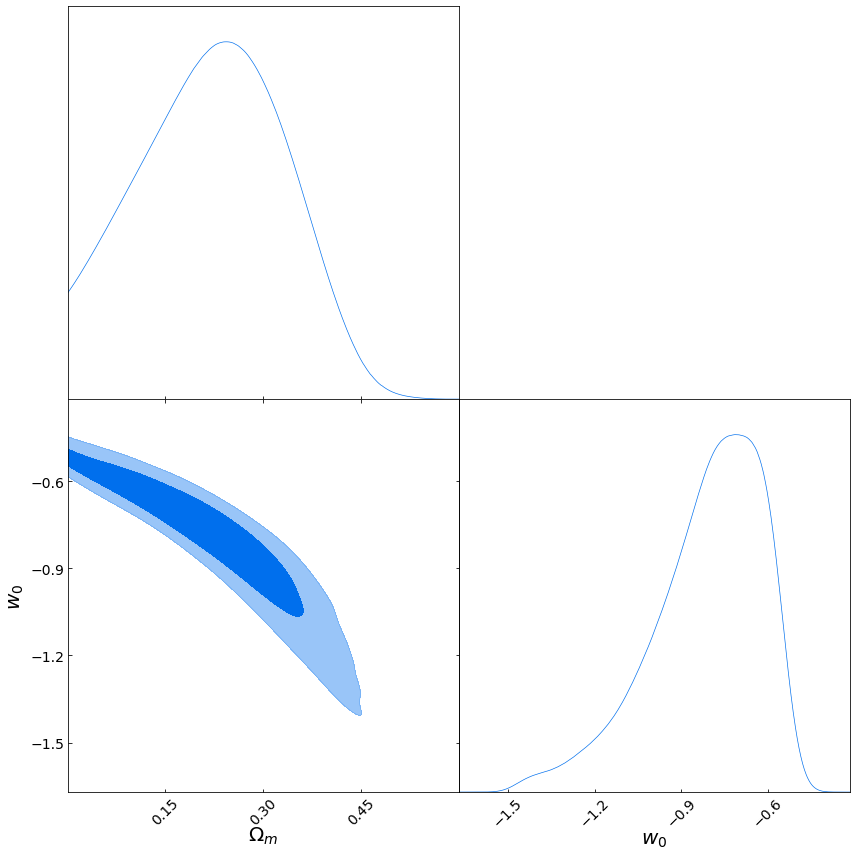

Population 59/59
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 10800 samples, validate on 1200 samples
Epoch 1/100
10800/10800 [==============================] - 14s 1ms/step - loss: 1.3354 - val_loss: 1.3575
Epoch 2/100
10800/10800 [==============================] - 14s 1ms/step - loss: 1.3350 - val_loss: 1.3543
Epoch 3/100
10800/10800 [==============================] - 13s 1ms/step - loss: 1.3337 - val_loss: 1.3525
Epoch 4/100
10800/10800 [==============================] - 13s 1ms/step - loss: 1.3340 - val_loss: 1.3575
Epoch 5/100
10800/10800 [==============================] - 13s 1ms/step - loss: 1.3339 - val_loss: 1.3512
Epoch 6/100
10800/10800 [==============================] - 13s 1ms/step - loss: 1.3341 - val_loss: 1.3543
Epoch 7/100
10800/10800 [==============================] - 13s 1ms/step - loss: 1.3340 - val_loss: 1.3540
Epoch 8/100
10800/10800 [==============================] - 13s 1ms/step - loss: 1.3331 - val_loss: 1.3588
Epoch 9/100
10800/10800 [

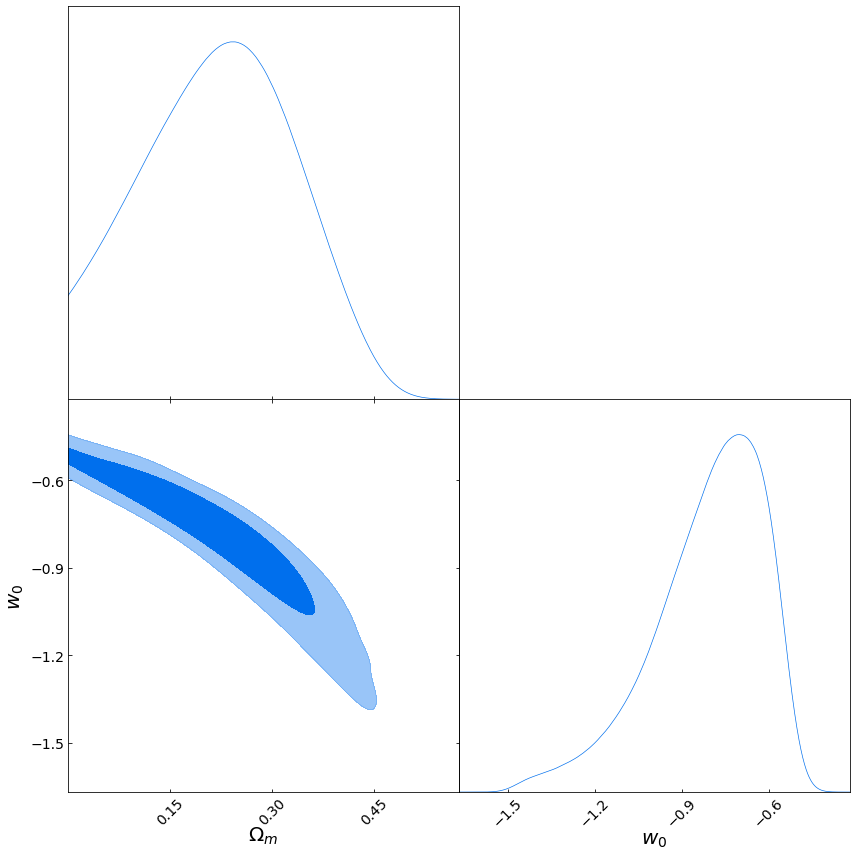

Final round of training with larger SGD batch size...
Train on 10800 samples, validate on 1200 samples
Epoch 1/300
10800/10800 [==============================] - 19s 2ms/step - loss: 1.3339 - val_loss: 1.3581
Epoch 2/300
10800/10800 [==============================] - 20s 2ms/step - loss: 1.3332 - val_loss: 1.3560
Epoch 3/300
10800/10800 [==============================] - 19s 2ms/step - loss: 1.3325 - val_loss: 1.3544
Epoch 4/300
10800/10800 [==============================] - 19s 2ms/step - loss: 1.3329 - val_loss: 1.3532
Epoch 5/300
10800/10800 [==============================] - 19s 2ms/step - loss: 1.3334 - val_loss: 1.3520
Epoch 6/300
10800/10800 [==============================] - 19s 2ms/step - loss: 1.3330 - val_loss: 1.3514
Epoch 7/300
10800/10800 [==============================] - 19s 2ms/step - loss: 1.3320 - val_loss: 1.3524
Epoch 8/300
10800/10800 [==============================] - 19s 2ms/step - loss: 1.3317 - val_loss: 1.3544
Epoch 9/300
10800/10800 [========================

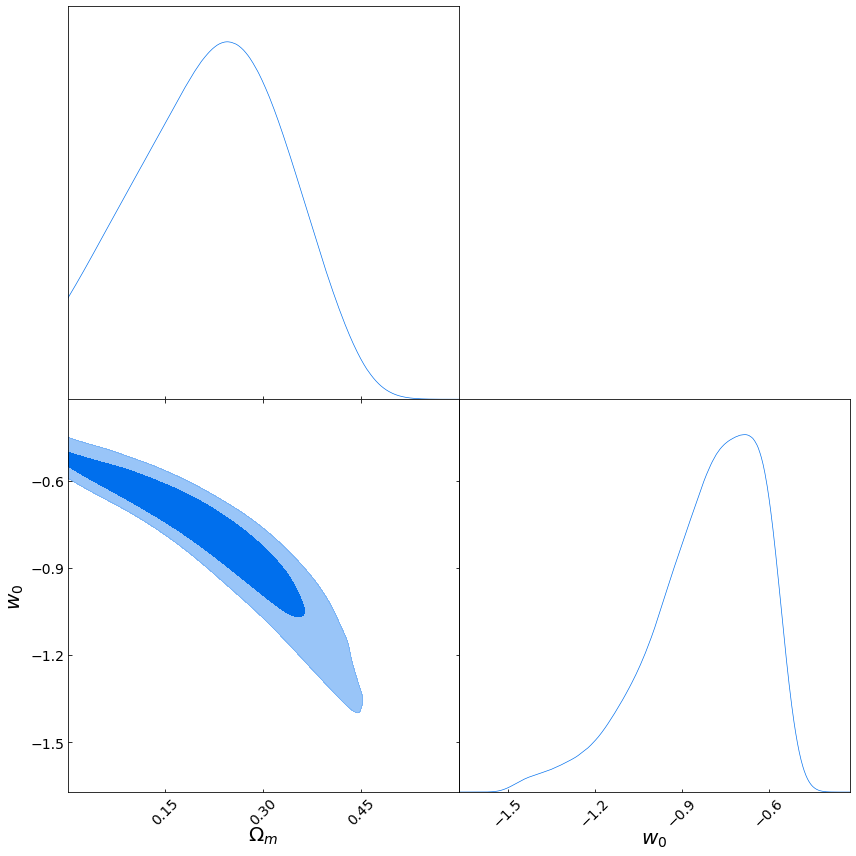

In [7]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 59

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

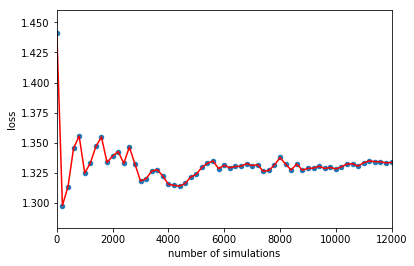

In [8]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()